In [1]:
import numpy as np
import pandas as pd
import os
import torch
from collections import defaultdict
from scipy.spatial.distance import jensenshannon
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import logomaker


import sys
sys.path.append("../2_train_models")

from file_configs import FoldFilesConfig, MergedFilesConfig
from data_loading import extract_peaks, extract_observed_profiles
from performance_metrics import compute_performance_metrics
from common_functions import load_coords
from common_functions import get_orientation_indexes, get_norm_shannon_entropies
from load_annotations_utils import find_peak_overlap_labels, get_ccre_bed, find_peak_overlap
from load_annotations_utils import load_coords_with_summits, get_gene_region_overlap, get_dist_to_TSS
from motif_hits_utils import load_motif_hits

from plot_utils import get_continuous_cmap
from plot_utils import jitter_dots, plot_scatter_and_boxplot

## Data Loading

In [2]:
# specify what set of models to look at
cell_type = "K562"

# the unique IDs for each of the folds / models in this cell type
timestamps = ["2023-05-29_15-51-40",
              "2023-05-29_15-58-41",
              "2023-05-29_15-59-09",
              "2023-05-30_01-40-06",
              "2023-05-29_23-21-23",
              "2023-05-29_23-23-45",
              "2023-05-29_23-24-11"]

# these usually don't change
model_type = "strand_merged_umap"
data_type = "procap"

# size of the model inputs and outputs
in_window = 2114
out_window = 1000

# motif names below are specific to the K562 profile modisco run
motif_names = ["BRE/SP", "CA-Inr", "ETS", "NFY", "NRF1", "ATF1", "TATA",
               "THAP11", "YY1", "AP1", "TA-Inr", "CTCF", "ZBTB33", "TCT", "TATATA"]

In [3]:
# Load the config objects (filepaths holders) for each fold a model was trained on

def load_fold_configs(cell_type, timestamps,
                      model_type = model_type, data_type = data_type):

    fold_configs = []
    for fold_i, timestamp in enumerate(timestamps):
        # folds are 1-indexed, and config constructor is expecting a string
        fold = str(fold_i + 1)
        
        # load the config object for this specific fold / model
        config = FoldFilesConfig(cell_type, model_type, fold, timestamp, data_type)
        fold_configs.append(config)
        
    return fold_configs

fold_configs = load_fold_configs(cell_type, timestamps)

Timestamp: 2023-05-29_15-51-40
Timestamp: 2023-05-29_15-58-41
Timestamp: 2023-05-29_15-59-09
Timestamp: 2023-05-30_01-40-06
Timestamp: 2023-05-29_23-21-23
Timestamp: 2023-05-29_23-23-45
Timestamp: 2023-05-29_23-24-11


In [4]:
# Load the config object for when model outputs were merged across all folds

merged_config = MergedFilesConfig(cell_type, model_type, data_type)

In [5]:
# these paths aren't specific to any model / fold, cell type, or data_type

proj_dir = merged_config.proj_dir

figures_dir = proj_dir + "figures/"
os.makedirs(figures_dir, exist_ok=True)

# this path will be the same for all models trained in the same cell type,
# and on the same data type (like procap)

data_dir = merged_config.data_dir

In [6]:
def get_pseudorep_filepaths(pseudorep, pos_or_neg, data_dir = data_dir):
    # Get paths to bigwigs for the pseudoreplicates of an experiment
    #  - pseudorep should be either an int (1-indexed) or an integer string
    
    assert pos_or_neg in ["pos", "neg"], pos_or_neg
    return os.path.join(data_dir, "pseudorep" + str(pseudorep) + "." + pos_or_neg + ".bigWig")


def load_pseudoreplicate_profiles(pseudorep, peaks_path, out_window=out_window):
    pos_bw_path = get_pseudorep_filepaths(pseudorep, "pos")
    neg_bw_path = get_pseudorep_filepaths(pseudorep, "neg")
    
    profs = extract_observed_profiles(pos_bw_path, neg_bw_path, peaks_path,
                                      out_window=out_window, verbose=True)
    return profs

In [7]:
all_coords = load_coords_with_summits(merged_config.all_peak_path, in_window)

In [8]:
def get_sort_order_test_sets(all_coords, fold_configs, in_window=in_window):
    # Each model / fold has a mutually exclusive test set; the order of the examples
    # in each test set differs from the order in the merged file of all examples.
    # So, this function figures out how to reorder the test set model predictions
    # so that they can be compared to the observed data.
    
    # First, load in the test set coordinates for each fold's test set
    
    test_coords = []
    for config in fold_configs:
        test_coords.extend(load_coords(config.test_peak_path, in_window))
        
    # Second, load in the test set coordinates for the merged file
    # (the "correct order")
    
    all_coords = load_coords(merged_config.all_peak_path, in_window)
    
    # Third, figure out the re-ordering needed to arrange the test coords
    # so they match the ordering in the merged file.
    # (then use that ordering later to fix the order of model predictions)
    
    sort_order = [test_coords.index(coord) for coord in all_coords]
    assert np.all(np.array(all_coords) == np.array(test_coords)[sort_order])
    
    return sort_order


def load_test_data(merged_config, fold_configs):
    true_profs = []
    true_counts = []
    pseudorep1_profs = []
    pseudorep2_profs = []
    log_pred_profs = []
    pred_logcounts = []
    
    for config in fold_configs:
        # Load observed data: replicate-merged PRO-cap signal
        obs_profs = extract_observed_profiles(config.plus_bw_path,
                                              config.minus_bw_path,
                                              config.test_peak_path,
                                              out_window=out_window,
                                              verbose=True)
        true_profs.extend(obs_profs)
        true_counts.extend(obs_profs.sum(axis=-1).squeeze())

        # Load PRO-cap signal for each pseudoreplicate individually (to see reproducibility)
        pseudorep1_profs.extend(load_pseudoreplicate_profiles(1, config.test_peak_path))
        pseudorep2_profs.extend(load_pseudoreplicate_profiles(2, config.test_peak_path))

        # Load model predictions
        log_pred_profs.extend(np.load(config.pred_profiles_test_path))
        pred_logcounts.extend(np.load(config.pred_logcounts_test_path).squeeze())
        
        # everything above should have loaded in the same number of examples/loci
        
        assert len(true_profs) == len(true_counts)
        assert len(pseudorep1_profs) == len(pseudorep2_profs)
        assert len(pseudorep1_profs) == len(true_counts)
        assert len(log_pred_profs) == len(pred_logcounts)
        assert len(pred_logcounts) == len(true_counts)
        
    true_profs = np.array(true_profs)
    true_counts = np.array(true_counts)
    pseudorep1_profs = np.array(pseudorep1_profs)
    pseudorep2_profs = np.array(pseudorep2_profs)
    log_pred_profs = np.array(log_pred_profs)
    pred_logcounts = np.array(pred_logcounts)
    
    sort_order = get_sort_order_test_sets(merged_config, fold_configs)
    
    true_profs = true_profs[sort_order]
    true_counts = true_counts[sort_order]
    pseudorep1_profs = pseudorep1_profs[sort_order]
    pseudorep2_profs = pseudorep2_profs[sort_order]
    log_pred_profs = log_pred_profs[sort_order]
    pred_logcounts = pred_logcounts[sort_order]
    
    pred_profs = np.exp(log_pred_profs)
    
    return true_profs, true_counts, pseudorep1_profs, pseudorep2_profs, pred_profs, pred_logcounts


true_profs, true_counts, pseudorep1_profs, pseudorep2_profs, \
                        pred_profs, pred_logcounts = load_test_data(merged_config, fold_configs)


Loading Profiles: 4334it [00:01, 4071.90it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334



Loading Profiles: 4334it [00:01, 4181.98it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334



Loading Profiles: 4334it [00:01, 4328.41it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334


Loading Profiles: 3699it [00:00, 4707.78it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699



Loading Profiles: 3699it [00:00, 4773.95it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699



Loading Profiles: 3699it [00:00, 4787.60it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699



Loading Profiles: 4559it [00:00, 4724.35it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559



Loading Profiles: 4559it [00:00, 4776.92it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559



Loading Profiles: 4559it [00:00, 4787.86it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559



Loading Profiles: 3887it [00:00, 4699.77it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887



Loading Profiles: 3887it [00:00, 4742.09it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887



Loading Profiles: 3887it [00:00, 4784.71it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887



Loading Profiles: 4470it [00:00, 4728.09it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470



Loading Profiles: 4470it [00:00, 4810.88it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470



Loading Profiles: 4470it [00:00, 4798.72it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470



Loading Profiles: 5238it [00:01, 4710.70it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238



Loading Profiles: 5238it [00:01, 4809.01it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238


Loading Profiles: 5238it [00:01, 4800.12it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238


Loading Profiles: 4347it [00:00, 4763.75it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347



Loading Profiles: 4347it [00:00, 4846.91it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347


Loading Profiles: 4347it [00:00, 4844.36it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347


## Calculate + Plot Model Performance on Test Sets

In [9]:
# To stratify performance across folds, we need to label
# each test example with which fold it was in the test set for.

# Fold assignment (below) needs to match what was in
# 1_process_data/_split_peaks_train_val_test.py

FOLDS = [["chr1", "chr4"],
         ["chr2", "chr13", "chr16"],
         ["chr5", "chr6", "chr20", "chr21"],
         ["chr7", "chr8", "chr9"],
         ["chr10", "chr11", "chr12"],
         ["chr3", "chr14", "chr15", "chr17"],
         ["chr18", "chr19", "chr22", "chrX", "chrY"]]

def get_fold_label(chrom):
    # returns *0-indexed* fold num that this chromosome was in the test set for
    for fold_i, fold_chroms in enumerate(FOLDS):
            if chrom in fold_chroms:
                return fold_i
    return -1

def make_fold_labels(coords):
    # Make list of len [num_peaks] / length of all_peak_path file,
    # where entry i is the fold that example i was in the test set for.
    
    # coord[0] is the chromosome (first column from bed file)
    fold_labels = [get_fold_label(coord[0]) for coord in coords]
    
    # check we assigned a fold for every single example/peak
    assert all([label > -1 for label in fold_labels]), fold_labels
    return fold_labels
        
    
fold_labels = make_fold_labels(all_coords)

### Counts Task Performance

In [10]:
def calc_pred_vs_obs_logcounts_pearson_over_folds(pred_logcounts, true_counts, fold_labels):
    pred_logcounts = pred_logcounts.squeeze()
    true_counts = true_counts.squeeze()
    
    # if the model preds/data are multi-stranded, sum across the two strands
    if len(pred_logcounts.shape) > 1:
        pred_logcounts = np.log(np.sum(np.exp(pred_logcounts), axis=-1))
    if len(true_counts.shape) > 1:
        true_counts = np.sum(true_counts, axis=-1)
    
    assert pred_logcounts.shape == true_counts.shape
    
    # assuming true counts, not log-counts
    true_logcounts = np.log1p(true_counts)
    
    folds = sorted(list(set(fold_labels)))
    
    pearson_rs = []
    for fold in folds:
        # convert numeric fold labels to booleans
        in_fold = np.array([fold_num == fold for fold_num in fold_labels])
        
        pred_logcounts_fold = pred_logcounts[in_fold]
        true_logcounts_fold = true_logcounts[in_fold]
        
        pearson_r = np.corrcoef(pred_logcounts_fold, true_logcounts_fold)[0,1]
        
        pearson_rs.append(pearson_r)
        
    print("Test Set Pearson Correlations, All Folds:")
    print(pearson_rs)
    
    print("\nAverage Within-Fold Test Pearson Correlation:")
    print(np.mean(pearson_rs))
    
    print("\nStandard Deviation of Pearson Correlation Across Folds:")
    print(np.std(pearson_rs))
    
    
calc_pred_vs_obs_logcounts_pearson_over_folds(pred_logcounts, true_counts, fold_labels)

Test Set Pearson Correlations, All Folds:
[0.7261634309354017, 0.7304255547600735, 0.7352390626583526, 0.7366682541351078, 0.7164102252529743, 0.7275918610299226, 0.659980040101723]

Average Within-Fold Test Pearson Correlation:
0.7189254898390793

Standard Deviation of Pearson Correlation Across Folds:
0.024846891779714386


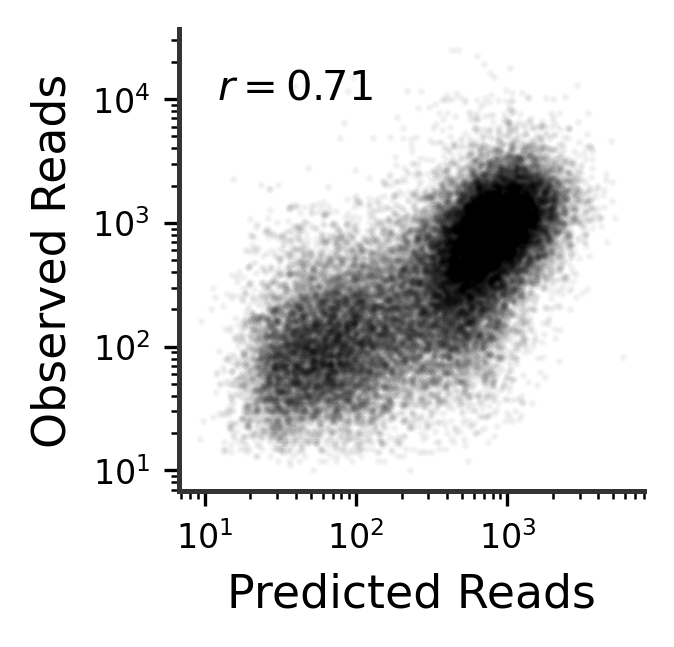

In [11]:
def plot_pred_vs_true_counts(pred_logcounts, true_counts, save_path = None):
    pred_logcounts = pred_logcounts.squeeze()
    true_counts = true_counts.squeeze()
    
    # if the model preds/data are multi-stranded, sum across the two strands
    if len(pred_logcounts.shape) > 1:
        pred_logcounts = np.log(np.sum(np.exp(pred_logcounts), axis=-1))
    if len(true_counts.shape) > 1:
        true_counts = np.sum(true_counts, axis=-1)
    
    assert pred_logcounts.shape == true_counts.shape
    
    pred_counts = np.exp(pred_logcounts)
    true_logcounts = np.log1p(true_counts)
    
    
    plt.figure(figsize=(2, 2), dpi=300)

    plt.scatter(pred_counts, true_counts,
                alpha = 0.03, s = 1, color="k")

    plt.semilogx()
    plt.semilogy()

    plt.ylabel("Observed Reads", fontsize=11)
    plt.xlabel("Predicted Reads", fontsize=11)
    
    # add the pearson correlation text to the top left
    # (coordinates hard-coded: adjust as neeeded)
    pearson_r = np.corrcoef(pred_logcounts, true_logcounts)[0,1]
    plt.text(12, 10000, r'$r = %0.2f$' % pearson_r, fontsize=10)

    # aesthetics
    ax = plt.gca()
    ax.spines[["left", "bottom"]].set_linewidth(1.2)
    ax.spines[["left", "bottom"]].set_color("#333333")
    ax.spines[["top", "right"]].set_visible(False)
    ax.tick_params("both", labelsize=8)
        
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
    
    
plot_pred_vs_true_counts(pred_logcounts, true_counts, save_path = figures_dir + "1C_pred_v_true_scatter.png")

### Profile Task Performance

In [12]:
def get_avg_train_obs_profile_over_folds(true_profs, fold_labels):
    # For each fold, calculate the average PRO-cap profile across all examples
    # in the training or validation (not-test) sets (to use as a baseline).
    # Then, build a list the same length as fold_labels, where the ith entry
    # is the average train-val profile for the fold that example i belonged to.
    
    folds = sorted(list(set(fold_labels)))
    
    avg_profiles = []
    for fold in folds:
        # convert numeric fold labels to booleans
        in_train_val_fold = np.array([fold_label != fold for fold_label in fold_labels])
        
        # subset to profiles that were in the train-val sets for this fold
        true_profs_fold = true_profs[in_train_val_fold]
        
        # calculate mean per-base, keeping strands separate
        avg_profiles.append(np.mean(true_profs_fold, axis=0))
        
    avg_profiles_tiled = []
    for fold_label in fold_labels:
        avg_profiles_tiled.append(avg_profiles[fold_label])
    return np.array(avg_profiles_tiled)

    
avg_profiles_over_folds = get_avg_train_obs_profile_over_folds(true_profs, fold_labels)

In [13]:
def calc_profile_jsds_and_corrs(profs1, profs2):
    assert profs1.shape == profs2.shape, (profs1.shape, profs2.shape)
    
    # assuming none of these profiles are in log-space

    jsds = []
    pearson_rs = []
    for prof1, prof2 in zip(profs1, profs2):
        # if multiple strands, flatten data across them into 1D array
        prof1 = prof1.flatten()
        prof2 = prof2.flatten()
        
        jsd = jensenshannon(prof1, prof2)
        jsds.append(jsd)
        
        pearson_r = np.corrcoef(prof1, prof2)[0,1]
        pearson_rs.append(pearson_r)
        
    return np.array(jsds), np.array(pearson_rs)
    
# compare model predictions vs. observed data on the test sets
jsds_pred_vs_obs, pearson_rs_pred_vs_obs = calc_profile_jsds_and_corrs(true_profs, pred_profs)

# baseline 1: observed data pseudoreplicate 1 vs. observed data pseudoreplicate 2 on test sets
jsds_pseudoreps, pearson_rs_pseudoreps = calc_profile_jsds_and_corrs(pseudorep1_profs, pseudorep2_profs)

# baseline 2: average data profile in the training + validation set vs. observed data on test sets
jsds_avg_baseline, pearson_rs_avg_baseline = calc_profile_jsds_and_corrs(true_profs, avg_profiles_over_folds)

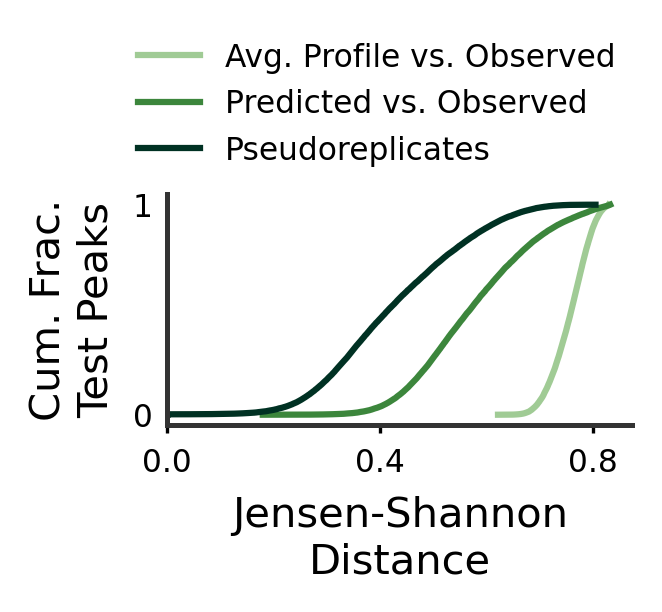

In [14]:
def plot_prof_jsds_cdf(pred_vs_obs, rep_baseline, avg_baseline,
                              save_path = None):

    fig = plt.figure(figsize=(2,1), dpi=300)
    
    pred_vs_obs = np.sort(pred_vs_obs)
    rep_baseline = np.sort(rep_baseline)
    avg_baseline = np.sort(avg_baseline)
    cdf = np.array(range(len(pred_vs_obs)))/float(len(pred_vs_obs))

    plt.plot(avg_baseline, cdf, color="#A0CB95", alpha=1, label="Avg. Profile vs. Observed")
    plt.plot(pred_vs_obs, cdf, color="#3C863C", alpha=1, label="Predicted vs. Observed")
    plt.plot(rep_baseline, cdf, color="#003123", alpha=1, label="Pseudoreplicates")
    
    plt.xlabel("Jensen-Shannon\nDistance", fontsize = 10)
    plt.ylabel("Cum. Frac.\nTest Peaks", fontsize = 10)
    
    plt.legend(fontsize=7.5, frameon=False, bbox_to_anchor=(0.45,1.78), loc="upper center")

    plt.xlim(-0, plt.gca().get_xlim()[1])
    plt.xticks([0, 0.4, 0.8], fontsize=6)

    plt.yticks([0, 1], fontsize=6)

    # aesthetics
    ax = plt.gca()
    ax.spines[["left", "bottom"]].set_linewidth(1.2)
    ax.spines[["left", "bottom"]].set_color("#333333")
    ax.spines[["top", "right"]].set_visible(False)
    
    ax.yaxis.set_ticks_position('none')
    ax.tick_params("y", length=0, labelsize=7.5)
    ax.tick_params("x", length=2, labelsize=7.5)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()


plot_prof_jsds_cdf(jsds_pred_vs_obs, jsds_pseudoreps, jsds_avg_baseline,
                   save_path = figures_dir + "1D_jsd_fix.png")

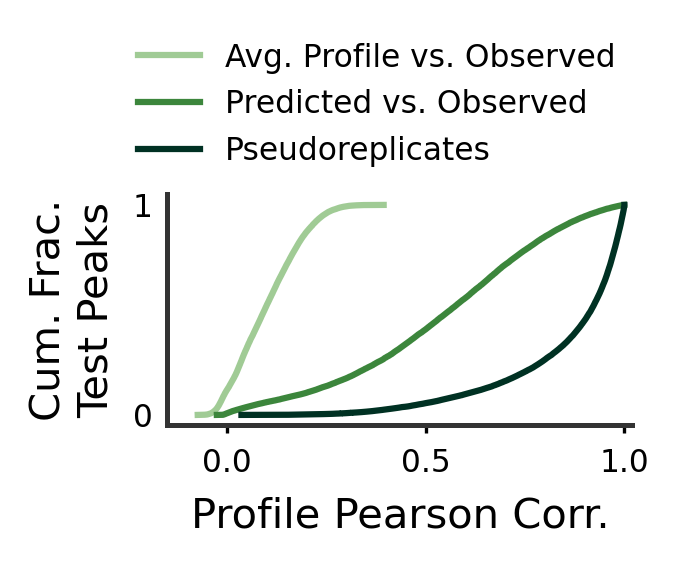

In [15]:
def plot_prof_pearson_rs_cdf(pred_vs_obs, rep_baseline, avg_baseline,
                              save_path = None):

    fig = plt.figure(figsize=(2,1), dpi=300)
    
    pred_vs_obs = np.sort(pred_vs_obs)
    rep_baseline = np.sort(rep_baseline)
    avg_baseline = np.sort(avg_baseline)
    cdf = np.array(range(len(pred_vs_obs)))/float(len(pred_vs_obs))

    plt.plot(avg_baseline, cdf, color="#A0CB95", alpha=1, label="Avg. Profile vs. Observed")
    plt.plot(pred_vs_obs, cdf, color="#3C863C", alpha=1, label="Predicted vs. Observed")
    plt.plot(rep_baseline, cdf, color="#003123", alpha=1, label="Pseudoreplicates")
    
    plt.xlabel("Profile Pearson Corr.", fontsize = 10)
    plt.ylabel("Cum. Frac.\nTest Peaks", fontsize = 10)
    
    plt.legend(fontsize=7.5, frameon=False, bbox_to_anchor=(0.45,1.78), loc="upper center")

    #plt.xlim(-0, plt.gca().get_xlim()[1])
    plt.xlim(-0.15, 1.02)
    #plt.xticks([0, 0.4, 0.8], fontsize=6)

    plt.yticks([0, 1], fontsize=6)

    # aesthetics
    ax = plt.gca()
    ax.spines[["left", "bottom"]].set_linewidth(1.2)
    ax.spines[["left", "bottom"]].set_color("#333333")
    ax.spines[["top", "right"]].set_visible(False)
    
    ax.yaxis.set_ticks_position('none')
    ax.tick_params("y", length=0, labelsize=7.5)
    ax.tick_params("x", length=2, labelsize=7.5)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()


plot_prof_pearson_rs_cdf(pearson_rs_pred_vs_obs, pearson_rs_pseudoreps, pearson_rs_avg_baseline,
                         save_path = figures_dir + "1D_pearson_r_fix.png")

### Normalize Performance Metrics

In [16]:
def normalize_profile_metric(metrics_pred_vs_obs, metrics_upper_bound, metrics_lower_bound,
                             bigger_is_worse = False):
    assert metrics_pred_vs_obs.shape == metrics_upper_bound.shape
    assert metrics_upper_bound.shape == metrics_lower_bound.shape
    
    # For each locus/peak/example, min-max normalize the performance metric
    # using the replicate performance as the upper bound and the "average profile"
    # baseline as the lower bound.
    
    norm_metrics = (metrics_pred_vs_obs - metrics_lower_bound) / (metrics_upper_bound - metrics_lower_bound)
    
    # If bigger values for the original metric mean worse performance,
    # we want the normalized metric to follow the same pattern,
    # so we need to flip the direction of the norm metric 
    if bigger_is_worse:
        norm_metrics = 1 - norm_metrics
    
    norm_metrics = np.clip(norm_metrics, 0, 1)
    return norm_metrics


norm_jsds = normalize_profile_metric(jsds_pred_vs_obs, jsds_pseudoreps, jsds_avg_baseline,
                                     bigger_is_worse = True)

norm_pearson_rs = normalize_profile_metric(pearson_rs_pred_vs_obs, pearson_rs_pseudoreps, pearson_rs_avg_baseline)

-0.7381399400849661


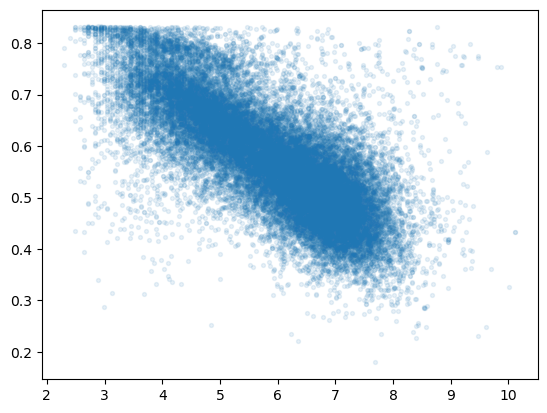

-0.20845428976116925


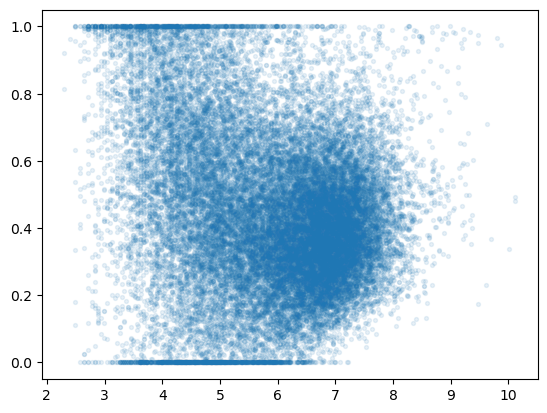

0.38356761074681883


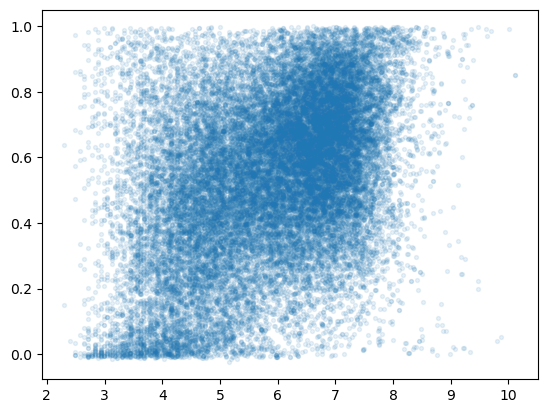

0.1535449324498849


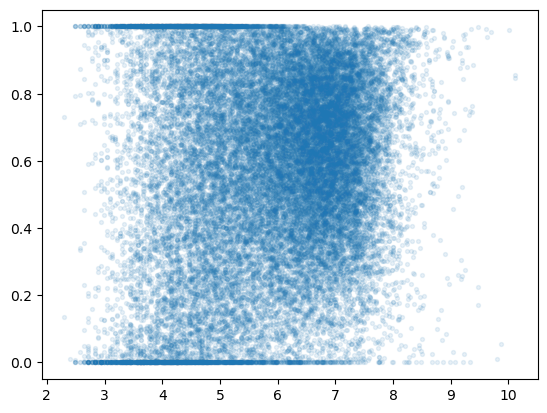

In [17]:
# why swap from JSDs to Pearson corrs: after normalization, corr is less confounded by counts?

print(np.corrcoef(np.log(true_counts.sum(axis=-1)), jsds_pred_vs_obs)[0,1])
plt.scatter(np.log(true_counts.sum(axis=-1)), jsds_pred_vs_obs, alpha=0.1, s=8)
plt.show()
print(np.corrcoef(np.log(true_counts.sum(axis=-1)), norm_jsds)[0,1])
plt.scatter(np.log(true_counts.sum(axis=-1)), norm_jsds, alpha=0.1, s=8)
plt.show()

print(np.corrcoef(np.log(true_counts.sum(axis=-1)), pearson_rs_pred_vs_obs)[0,1])
plt.scatter(np.log(true_counts.sum(axis=-1)), pearson_rs_pred_vs_obs, alpha=0.1, s=8)
plt.show()
print(np.corrcoef(np.log(true_counts.sum(axis=-1)), norm_pearson_rs)[0,1])
plt.scatter(np.log(true_counts.sum(axis=-1)), norm_pearson_rs, alpha=0.1, s=8)
plt.show()

In [18]:
def stratify_profile_metrics_over_folds(prof_metrics, fold_labels):
    folds = sorted(list(set(fold_labels)))
    
    aggregated_metric_per_fold = []
    for fold in folds:
        # convert numeric fold labels to booleans
        in_fold = np.array([fold_num == fold for fold_num in fold_labels])
        
        prof_metrics_fold = prof_metrics[in_fold]
        
        aggregated_metric_per_fold.append(np.mean(prof_metrics_fold))
        
    print("Metric Average Within Each Fold's Test Set:")
    print(aggregated_metric_per_fold)
    
    print("\nMetric Average, Averaged Across Folds:")
    print(np.mean(aggregated_metric_per_fold))
    
    print("\nStandard Deviation of Metric Average Across Folds:")
    print(np.std(aggregated_metric_per_fold), "\n")
    

print("--- Pearson Corr ---")
stratify_profile_metrics_over_folds(pearson_rs_pred_vs_obs, fold_labels)

print("--- Normalized Pearson Corr ---")
stratify_profile_metrics_over_folds(norm_pearson_rs, fold_labels)

print("--- JSD ---")
stratify_profile_metrics_over_folds(jsds_pred_vs_obs, fold_labels)

print("--- Normalized JSD ---")
stratify_profile_metrics_over_folds(norm_jsds, fold_labels)

--- Pearson Corr ---
Metric Average Within Each Fold's Test Set:
[0.5391643930372261, 0.5501057186351691, 0.5234672878400162, 0.5310877059070708, 0.5387542380879435, 0.5485743043879798, 0.5501547345992182]

Metric Average, Averaged Across Folds:
0.5401869117849463

Standard Deviation of Metric Average Across Folds:
0.009513359378455535 

--- Normalized Pearson Corr ---
Metric Average Within Each Fold's Test Set:
[0.5739815546420901, 0.5847476703567741, 0.5578779233694028, 0.5626139379172975, 0.5774083499434065, 0.5860677714574687, 0.5898065528671115]

Metric Average, Averaged Across Folds:
0.5760719657933644

Standard Deviation of Metric Average Across Folds:
0.01122573763435877 

--- JSD ---
Metric Average Within Each Fold's Test Set:
[0.575244808394881, 0.5720277367606037, 0.5824383820226973, 0.5787674902922884, 0.5788698907806228, 0.573797342004883, 0.5753261286755628]

Metric Average, Averaged Across Folds:
0.5766388255616485

Standard Deviation of Metric Average Across Folds:
0.00

In [19]:
# repeat for baselines


print("--- Pearson Corr, Pseudoreplicate Baseline ---")
stratify_profile_metrics_over_folds(pearson_rs_pseudoreps, fold_labels)

print("--- Pearson Corr, Average Profile Baseline ---")
stratify_profile_metrics_over_folds(pearson_rs_avg_baseline, fold_labels)

print("--- JSD, Pseudoreplicate Baseline ---")
stratify_profile_metrics_over_folds(jsds_pseudoreps, fold_labels)

print("--- JSD, Average Profile Baseline ---")
stratify_profile_metrics_over_folds(jsds_avg_baseline, fold_labels)

--- Pearson Corr, Pseudoreplicate Baseline ---
Metric Average Within Each Fold's Test Set:
[0.8542737981578994, 0.8599293268726624, 0.8506581746785598, 0.8498837983291898, 0.8455258524148139, 0.8555937659171714, 0.8462258760192383]

Metric Average, Averaged Across Folds:
0.8517272274842193

Standard Deviation of Metric Average Across Folds:
0.004810295531031557 

--- Pearson Corr, Average Profile Baseline ---
Metric Average Within Each Fold's Test Set:
[0.09690556495190251, 0.10272996859786046, 0.09541558560870526, 0.1008523306778426, 0.1016669123055243, 0.10322813209232269, 0.10180564396685782]

Metric Average, Averaged Across Folds:
0.10037201974300225

Standard Deviation of Metric Average Across Folds:
0.0027842047456078808 

--- JSD, Pseudoreplicate Baseline ---
Metric Average Within Each Fold's Test Set:
[0.4202261073095377, 0.4221872216749372, 0.4263383876056469, 0.42725697825625525, 0.43347518976231875, 0.42542549616824593, 0.431017125569182]

Metric Average, Averaged Across Fol

## Plot Individual Example Loci + Model Predictions

In [20]:
prof_scores = np.load(merged_config.profile_onehot_scores_path)
counts_scores = np.load(merged_config.counts_onehot_scores_path)

In [21]:
# helper functions so that I can find the exact PRO-cap peak matching
# where I found something in the genome browser

def _overlap(coord1, coord2):
    # chromosome should be the same
    if coord1[0] != coord2[0]:
        return False
    if coord2[2] < coord1[1]:
        return False
    if coord2[1] > coord1[2]:
        return False
    return True

def get_locus_index(coords, chrom, start, end):
    # returns the peak index and the peak coordinates for whatever PRO-cap peak
    # is the closest match to the chrom-start-end info you input
    
    assert type(chrom) == str, chrom
    assert type(start) == int, start
    assert type(end) == int, end
    coord_to_find = (chrom, start, end)
    
    match_indexes = []
    matches = []
    for index, coord in enumerate(coords):
        if _overlap(coord, coord_to_find):
            matches.append(coord)
            match_indexes.append(index)
            
    if len(matches) == 0:
        print("Coordinate not found :(")
        return None
    elif len(matches) > 1:
        print(str(len(matches)) + " matches to coordinate found: ", coord_to_find)
    else:
        print(coord_to_find, "--->", matches[0])
        return match_indexes[0], matches[0]
        
    mid_for_coord_to_find = (start + end) // 2
    dists_for_matches = [abs(((c[1] + c[2]) // 2) - mid_for_coord_to_find) for c in matches]
    closest_match_index = match_indexes[np.argmin(dists_for_matches)]
    closest_match = matches[np.argmin(dists_for_matches)]
    
    print(coord_to_find, "--->", closest_match)
    
    return closest_match_index, closest_match
        

tal1_altpromoter_index, _ = get_locus_index(all_coords, "chr1", 47231230, 47231655)
gata1_enhancer_index, _ = get_locus_index(all_coords, "chrX", 48789633, 48789866)
hbe1_promoter_index, hbe1_promoter_coords = get_locus_index(all_coords, "chr11", 5269828, 5270185)
hbe1_enhancer_index, hbe1_enhancer_coords = get_locus_index(all_coords, "chr11", 5288180, 5288433)

# ended up going with these:
pola1_promoter_index, pola1_promoter_coords = get_locus_index(all_coords, "chrX", 24693718, 24693987)
pola1_enhancer_index, pola1_enhancer_coords = get_locus_index(all_coords, "chrX", 24297329, 24297563)

2 matches to coordinate found:  ('chr1', 47231230, 47231655)
('chr1', 47231230, 47231655) ---> ('chr1', 47230428, 47232542, 47231419, 47231261)
('chrX', 48789633, 48789866) ---> ('chrX', 48788692, 48790806, 48789865, 48789664)
('chr11', 5269828, 5270185) ---> ('chr11', 5268953, 5271067, 5270098, 5269942)
('chr11', 5288180, 5288433) ---> ('chr11', 5287265, 5289379, 5288334, 5288250)
('chrX', 24693718, 24693987) ---> ('chrX', 24692804, 24694918, 24693920, 24693752)
('chrX', 24297329, 24297563) ---> ('chrX', 24296353, 24298467, None, 24297416)


In [22]:
def plot_motif_on_ax_modified(pwm, ax):
    # "modified" = different from the version of this function in other_motif_utils.py,
    # because the axes have to be treated differently for this megaplot
    
    # given a PWM/CWM/contribution scores array and a matplotlib axis, this function
    # draws the letters at the heights specificed by the array
    
    # expecting either (n x 4) motif or (n x 4) one-hot encoded scores
    assert len(pwm.shape) == 2 and pwm.shape[-1] == 4, pwm.shape
    # reformat pwm to what logomaker expects
    df = pd.DataFrame(pwm, columns=['A', 'C', 'G', 'T'])
    df.index.name = 'pos'

    # plot motif ("baseline_width=0" removes the y=0 line)
    logomaker.Logo(df, ax=ax, font_name='Arial Rounded', baseline_width=0)
    
    ax.set_ylim(min(df.sum(axis=1).min(), 0), df.sum(axis=1).max())


def plot_example(true_profile, pred_profile, prof_scores, counts_scores,
                 locus_coords, zoom_mid = None, zoom_width = None, in_window = in_window,
                 prof_len = out_window, title = None, linewidth=None, label_strands = True,
                 imp_score_pad = 0.185, fig_width = 3, save_path = None):
    
    num_subplots = 4
    
    fig, axes = plt.subplots(num_subplots, figsize=(fig_width, 2.7),
                             sharex=True, dpi=300,
                             gridspec_kw = {"height_ratios" : [1,1,0.6,0.75]})
    plt.tight_layout(pad=0)
    
    if title is not None:
        fig.suptitle(title, x=0.53, y = 1.08, fontsize=14, horizontalalignment='center')
    
    axis_fontsize = 10
    prof_linewidth = 1.2
    if linewidth is not None:
        prof_linewidth *= linewidth
    
    
    # plot the observed profile, both strands
    
    x_range = np.arange(0,prof_len)
    offset = np.max(np.abs(true_profile)) * 0.02  # offset needed to see both strands' lines
    
    axes[0].plot(x_range, true_profile[0] + offset,
                 alpha=1, c = "#001DAC", linewidth=prof_linewidth)
    axes[0].plot(x_range, -1 * true_profile[1] - offset,
                 alpha=0.7, c = "#001DAC", linewidth=prof_linewidth)
    axes[0].set_ylabel("Observed\nReads", fontsize = axis_fontsize)
    
    
    # plot the predicted profile, both strands
    
    offset = np.max(np.abs(pred_profile)) * 0.02
    
    axes[1].plot(x_range, pred_profile[0] + offset,
                 alpha=1, c = "#1B5AE3", linewidth=prof_linewidth)
    axes[1].plot(x_range, -1 * pred_profile[1] - offset,
                 alpha=0.7, c = "#1B5AE3", linewidth=prof_linewidth)
    axes[1].set_ylabel("Predicted\nReads", fontsize = axis_fontsize)
    
    print("Correlation between predicted and observed profile in this window:")
    print(np.corrcoef(true_profile[:, zoom_mid - zoom_width : zoom_mid + zoom_width].flatten(),
            pred_profile[:, zoom_mid - zoom_width : zoom_mid + zoom_width].flatten())[0,1])

    
    # plot the profile and counts task contribution scores
    
    # need to slice accounting for difference between score width (input size of model)
    # vs. pred or obs profile width (output size of model)
    in_out_size_diff = (in_window - out_window) // 2
    prof_scores = prof_scores[:, in_out_size_diff : in_window - in_out_size_diff]
    counts_scores = counts_scores[:, in_out_size_diff : in_window - in_out_size_diff]
    
    plot_motif_on_ax_modified(prof_scores.T, axes[2])
    plot_motif_on_ax_modified(counts_scores.T, axes[3])
    
    axes[2].set_ylabel(" Profile", fontsize = axis_fontsize - 2)
    axes[3].set_ylabel("Counts ", fontsize = axis_fontsize - 2)
    
    axes[2].annotate("Importance\nScores",
            xy=(0, 0), xycoords='axes fraction',
            xytext=(-imp_score_pad, -0.35), textcoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',
            fontsize=axis_fontsize, rotation=90)
    
    
    # zoom into correct position, set x-axis tick values to actual coordinates
    
    if zoom_mid is not None and zoom_width is not None:
        zoom_lims = (zoom_mid - zoom_width, zoom_mid + zoom_width)
        plt.xlim(zoom_lims)
        
        # this should be 2114
        locus_coords_width = locus_coords[2] - locus_coords[1]
        # a 0 on this plot's axis corresponds to position [xticks_offset] on this chromosome
        xticks_offset = locus_coords[1] + (locus_coords_width - prof_len) // 2
        
        # modify the xticks to reflect actual genomic coordinates
        og_xticks = axes[-1].get_xticks()[1:-1:2]
        xticks = [int(xt + xticks_offset) for xt in og_xticks]
        plt.xticks(og_xticks, xticks)
        
        axes[-1].set_xlabel(locus_coords[0], style="italic")
    else:
        x_axis_buffer = 10
        plt.xlim(- x_axis_buffer, prof_len + x_axis_buffer)
        
        axes[-1].set_xlabel("Genomic Axis", fontsize = axis_fontsize)
    
    
    # aesthetics
    
    # plot y-axis for profiles, not for scores
    
    for ax in axes[:2]:
        ax.tick_params("y", length=0, labelsize=9)
        ax.set_yticks(ax.get_yticks(minor=False)[1:-1],
                      np.abs(ax.get_yticks(minor=False)).astype(int)[1:-1])
        
    for ax in axes[2:]:
        ax.set_yticks([])
        
    # only draw x-axis line for bottom plot
    
    for ax in axes[:-1]:
        ax.spines["bottom"].set_visible(False)
        ax.tick_params("x", length=0)
            
    axes[-1].spines["bottom"].set_linewidth(1.5)
    axes[-1].spines["bottom"].set_color("#333333")
    axes[-1].tick_params("x", labelsize=9)
    
    for ax in axes:
        ax.spines[["top", "right"]].set_visible(False)
        ax.spines["left"].set_linewidth(1.5)
        ax.spines["left"].set_color("#333333")

    # put more space between scoes and x-axis line
    
    axes[-1].set_ylim(axes[-1].get_ylim()[0] * 2.5, axes[-1].set_ylim()[1])
    
    
    # add little text near edge of profile saying that the two lines are the two strands
    
    if label_strands == True:
        ymin, ymax = axes[0].get_ylim()
        zero_point = - ymin / (ymax - ymin)
        
        axes[0].annotate(r'$fwd. strand$',
            xy=(0.1, 0.1), xycoords='axes fraction',
            xytext=(0.03, zero_point + 0.2), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=7, color="#001DAC", alpha=0.9)
        axes[0].annotate(r'$rev. strand$',
            xy=(0.1, 0.1), xycoords='axes fraction',
            xytext=(0.03, zero_point - 0.08), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=7, color="#001DAC", alpha=0.6)
        
    elif label_strands == "right":
        ymin, ymax = axes[0].get_ylim()
        zero_point = - ymin / (ymax - ymin)
        
        axes[0].annotate(r'$fwd. strand$',
            xy=(0.1, 0.1), xycoords='axes fraction',
            xytext=(1, zero_point + 0.2), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top',
            fontsize=7, color="#001DAC", alpha=0.9)
        axes[0].annotate(r'$rev. strand$',
            xy=(0.1, 0.1), xycoords='axes fraction',
            xytext=(1, zero_point - 0.08), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top',
            fontsize=7, color="#001DAC", alpha=0.6)
    
    
    fig.align_ylabels(axes[:2])
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()

findfont: Font family ['Arial Rounded'] not found. Falling back to DejaVu Sans.


Correlation between predicted and observed profile in this window:
0.871960597342831


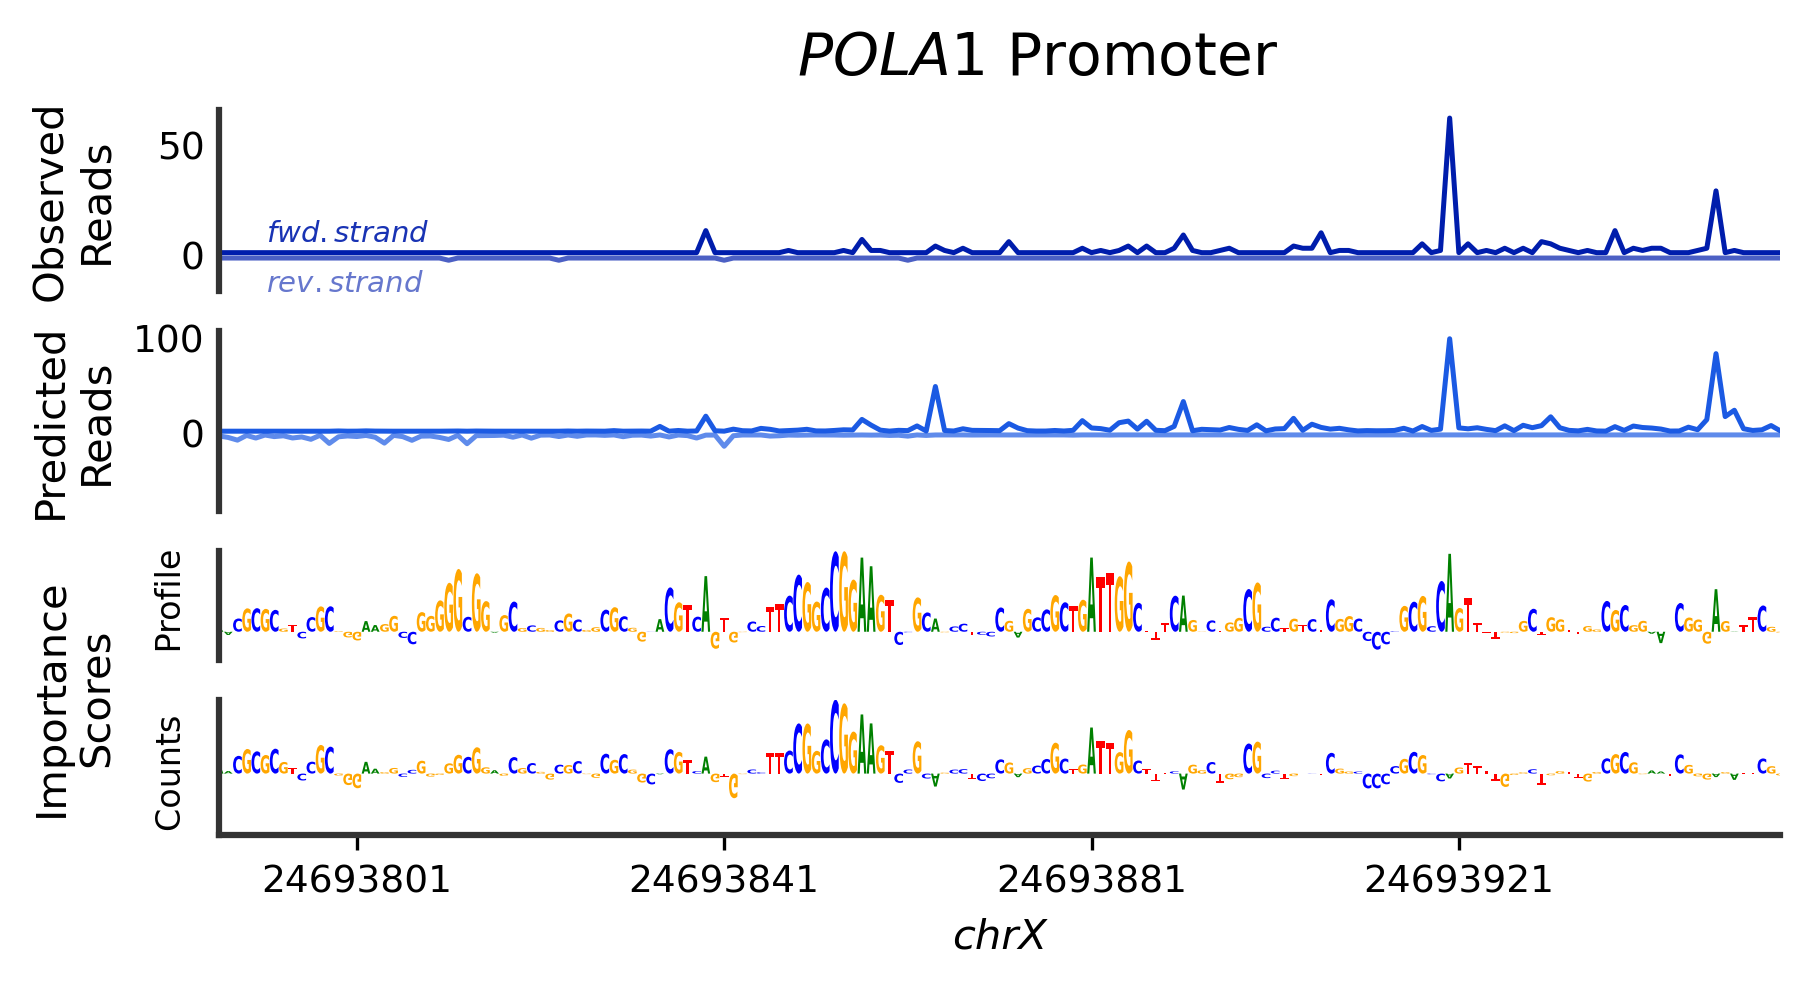

In [23]:
plot_example(true_profs[pola1_promoter_index],
             pred_profs[pola1_promoter_index] * np.exp(pred_logcounts[pola1_promoter_index]),
             prof_scores[pola1_promoter_index],
             counts_scores[pola1_promoter_index],
             pola1_promoter_coords, zoom_mid = 510, zoom_width = 85,
             imp_score_pad = 0.0925, fig_width = 5.5,
             title=r'$\it{POLA1}$ Promoter', label_strands = True,
             save_path = figures_dir + "1B_pola1_promoter.png")

Correlation between predicted and observed profile in this window:
0.9461167276830837


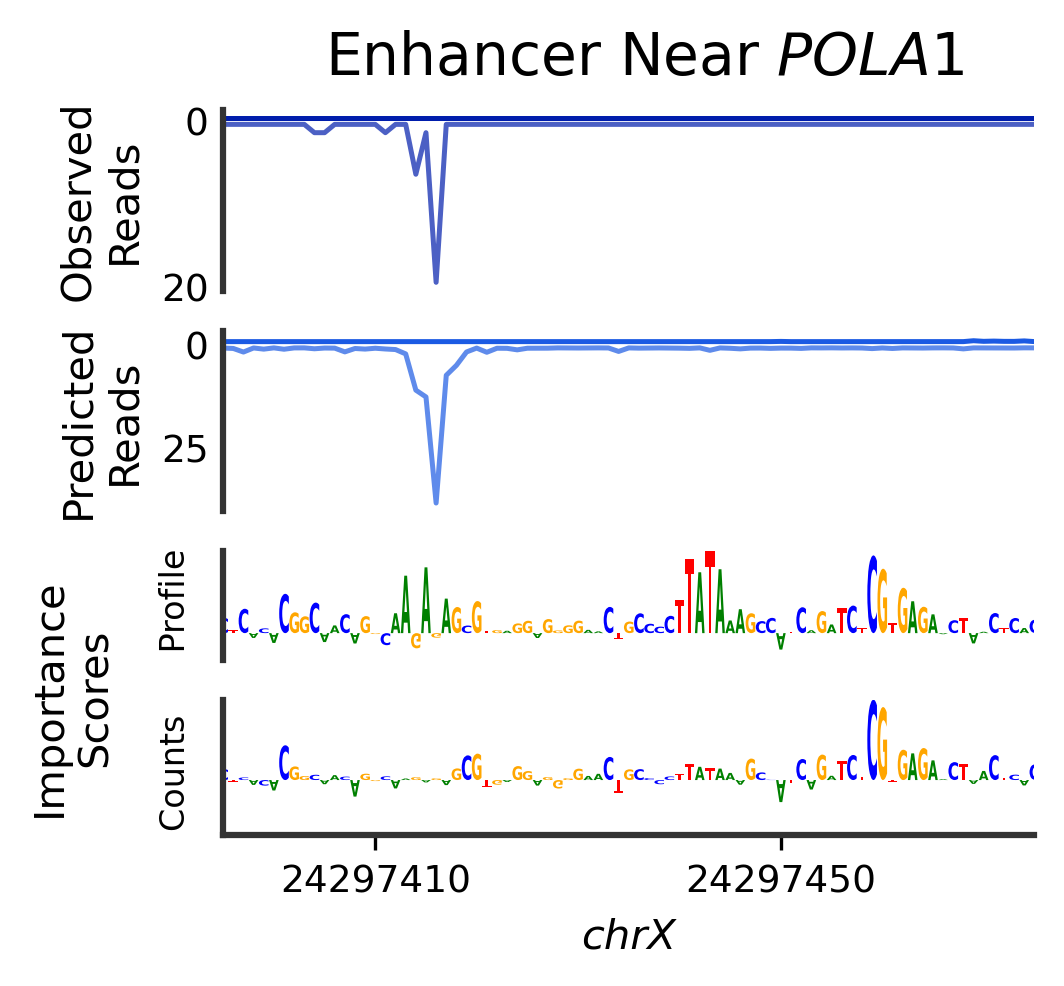

In [24]:
plot_example(true_profs[pola1_enhancer_index],
             pred_profs[pola1_enhancer_index] * np.exp(pred_logcounts[pola1_enhancer_index]),
             prof_scores[pola1_enhancer_index],
             counts_scores[pola1_enhancer_index],
             pola1_enhancer_coords, zoom_mid = 525, zoom_width = 40,
             title=r'Enhancer Near $\it{POLA1}$', label_strands = False,
             
            save_path = figures_dir + "1B_pola1_enhancer.png")

## Stratify Model Performance Over Possible Covariates

In [25]:
ois = get_orientation_indexes(true_profs)
nsis = get_norm_shannon_entropies(true_profs, true_counts)

0.23133847364324345


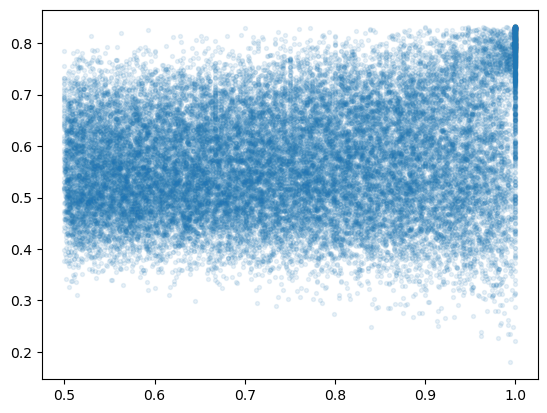

0.34323546391239584


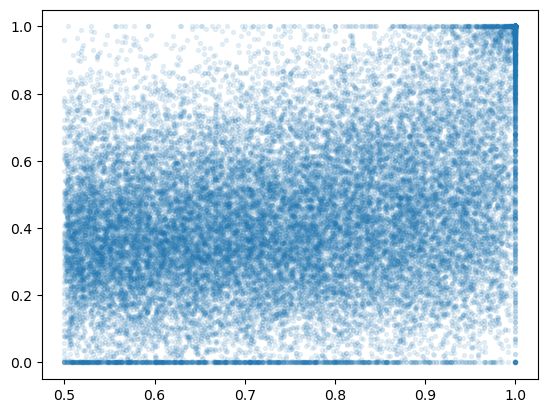

-0.13332029703703185


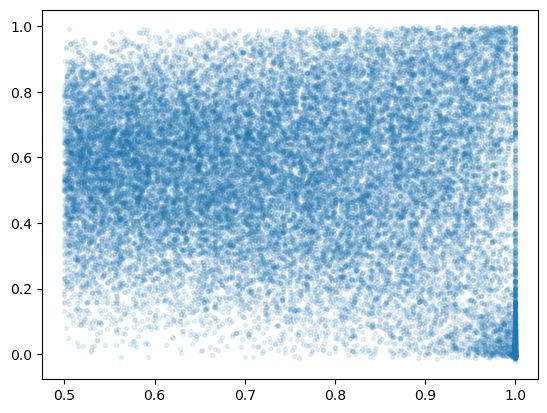

-0.14963403816205365


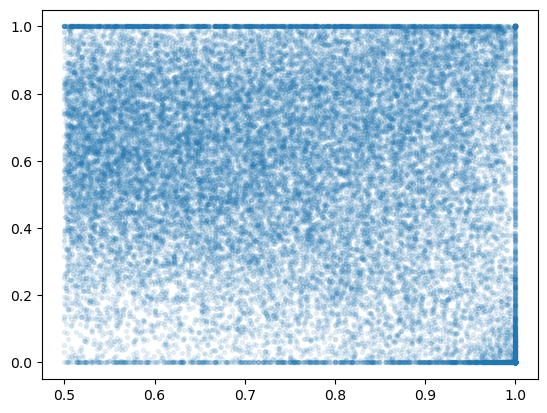

In [26]:
print(np.corrcoef(ois, jsds_pred_vs_obs)[0,1])
plt.scatter(ois, jsds_pred_vs_obs, alpha=0.1, s=8)
plt.show()

print(np.corrcoef(ois, norm_jsds)[0,1])
plt.scatter(ois, norm_jsds, alpha=0.1, s=8)
plt.show()

print(np.corrcoef(ois, pearson_rs_pred_vs_obs)[0,1])
plt.scatter(ois, pearson_rs_pred_vs_obs, alpha=0.1, s=8)
plt.show()
print(np.corrcoef(ois, norm_pearson_rs)[0,1])
plt.scatter(ois, norm_pearson_rs, alpha=0.1, s=8)
plt.show()

0.3424084479385151


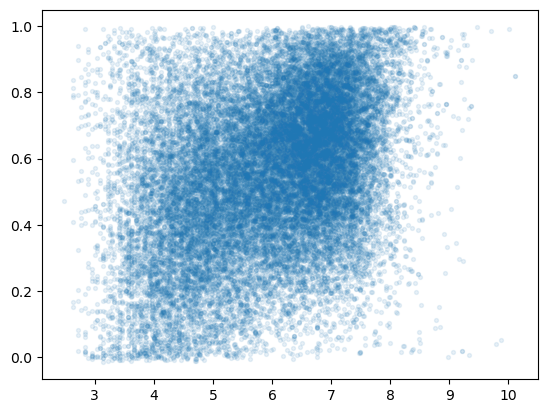

0.08993283549727722


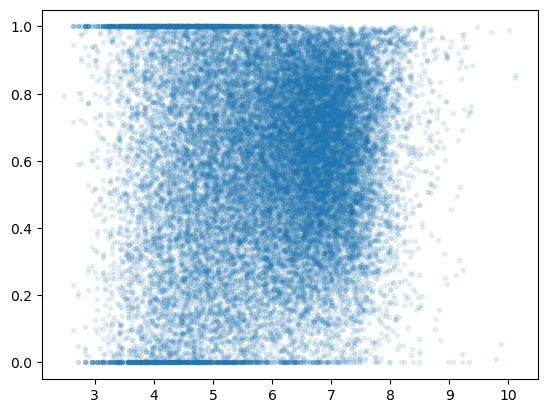

In [27]:
print(np.corrcoef(np.log(true_counts.sum(axis=-1))[ois < 0.99], pearson_rs_pred_vs_obs[ois < 0.99])[0,1])
plt.scatter(np.log(true_counts.sum(axis=-1))[ois < 0.99], pearson_rs_pred_vs_obs[ois < 0.99], alpha=0.1, s=8)
plt.show()
print(np.corrcoef(np.log(true_counts.sum(axis=-1))[ois < 0.99], norm_pearson_rs[ois < 0.99])[0,1])
plt.scatter(np.log(true_counts.sum(axis=-1))[ois < 0.99], norm_pearson_rs[ois < 0.99], alpha=0.1, s=8)
plt.show()

Pearson r, metric vs. covariate: 0.3432354639123959
Pearson r, metric vs. covariate: -0.2909333941962588
Pearson r, metric vs. covariate: 0.23133847364324345
Pearson r, metric vs. covariate: 0.05018000369859267
Pearson r, metric vs. covariate: -0.14963403816205365
Pearson r, metric vs. covariate: 0.010345641439902943
Pearson r, metric vs. covariate: -0.13332029703703188
Pearson r, metric vs. covariate: -0.1374026063976692


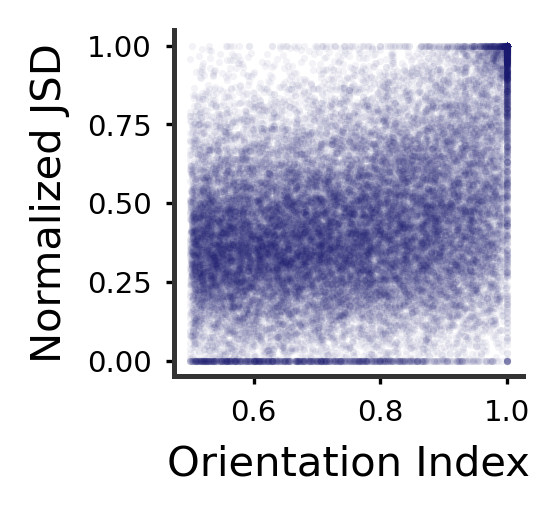

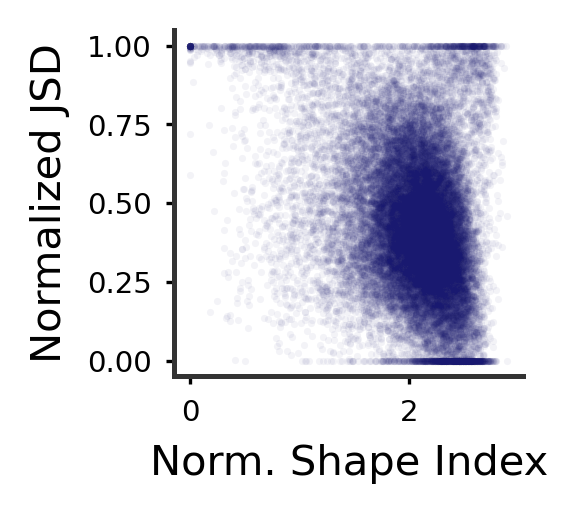

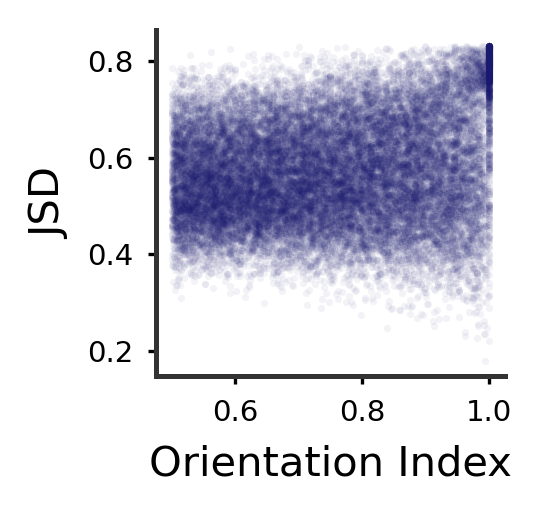

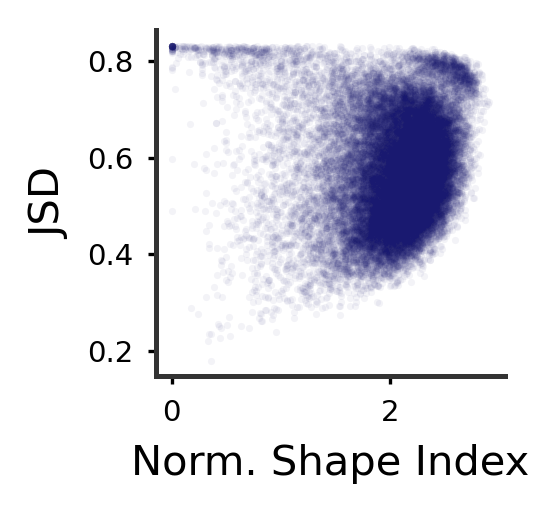

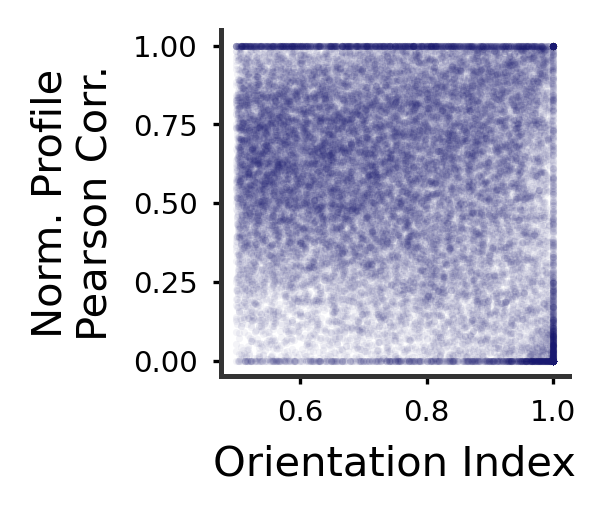

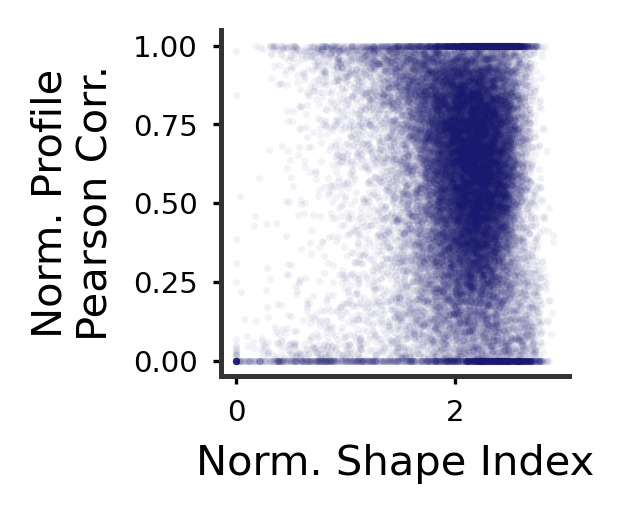

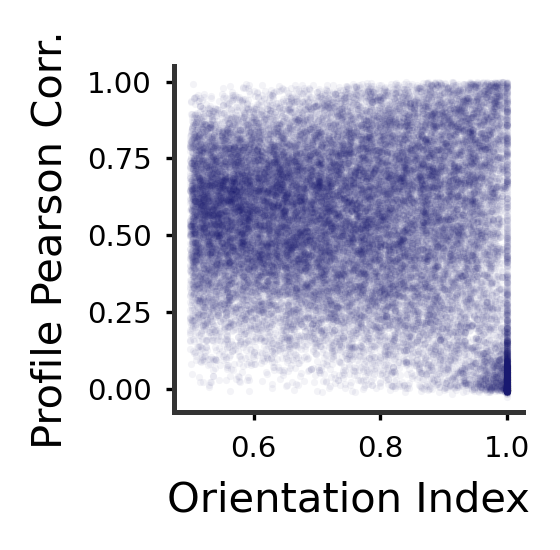

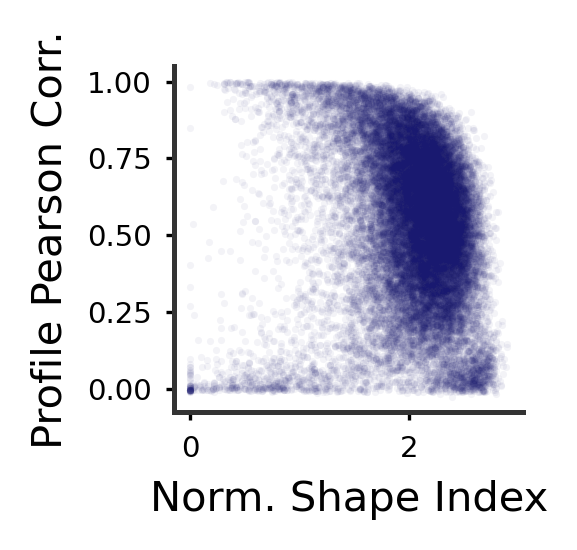

In [28]:
def plot_metrics_by_covariate(metrics, covariate, xlabel, ylabel, save_path = None):
    print("Pearson r, metric vs. covariate:", np.corrcoef(metrics, covariate)[0,1])
    
    plt.figure(figsize=(1.5, 1.5), dpi=300)
    
    plt.scatter(covariate,
                metrics,
                s = 3, alpha=0.05, linewidths=0, color="midnightblue")

    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    
    # aesthetics
    ax = plt.gca()
    ax.spines[["left", "bottom"]].set_linewidth(1.2)
    ax.spines[["left", "bottom"]].set_color("#333333")
    ax.spines[["top", "right"]].set_visible(False)
    ax.tick_params(length=2, labelsize=7)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
        

plot_metrics_by_covariate(norm_jsds, ois, "Orientation Index", "Normalized JSD",
                          save_path = figures_dir + "S1_OI_by_norm_jsd.png")
plot_metrics_by_covariate(norm_jsds, nsis, "Norm. Shape Index", "Normalized JSD",
                          save_path = figures_dir + "S1_NSI_by_norm_jsd.png")

plot_metrics_by_covariate(jsds_pred_vs_obs, ois, "Orientation Index", "JSD",
                          save_path = figures_dir + "S1_OI_by_jsd.png")
plot_metrics_by_covariate(jsds_pred_vs_obs, nsis, "Norm. Shape Index", "JSD",
                          save_path = figures_dir + "S1_NSI_by_jsd.png")

plot_metrics_by_covariate(norm_pearson_rs, ois, "Orientation Index", "Norm. Profile\nPearson Corr.",
                          save_path = figures_dir + "S1_OI_by_norm_pearson.png")
plot_metrics_by_covariate(norm_pearson_rs, nsis, "Norm. Shape Index", "Norm. Profile\nPearson Corr.",
                          save_path = figures_dir + "S1_NSI_by_norm_pearson.png")
    
plot_metrics_by_covariate(pearson_rs_pred_vs_obs, ois, "Orientation Index", "Profile Pearson Corr.",
                          save_path = figures_dir + "S1_OI_by_pearson.png")
plot_metrics_by_covariate(pearson_rs_pred_vs_obs, nsis, "Norm. Shape Index", "Profile Pearson Corr.",
                          save_path = figures_dir + "S1_NSI_by_pearson.png")

## Stratify Model Performance Across cCREs

In [29]:
# essentially, run bedtools intersect between PRO-cap peaks and cCRE annotations
# (takes a second to run)

# cCRE annotations are cell-type-specific, from ENCODE 2020 paper:
#  "Expanded encyclopaedias of DNA elements in the human and mouse genomes." (Nature)

ccre_annots = find_peak_overlap_labels(all_coords,
                                       get_ccre_bed(cell_type, proj_dir),
                                       in_window, out_window)

# break down category of "promoter" (PLS) into promoters
# with vs. without proximal enhancers (pELS)

ccre_annots["PLS_no_pELS"] = ccre_annots["PLS"] * (~ ccre_annots["pELS"])
ccre_annots["PLS_with_pELS"] = ccre_annots["PLS"] * ccre_annots["pELS"]

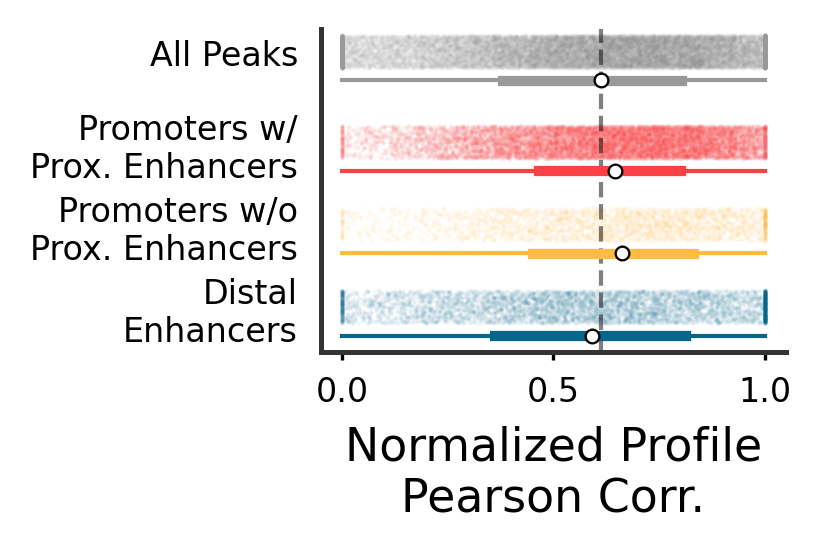

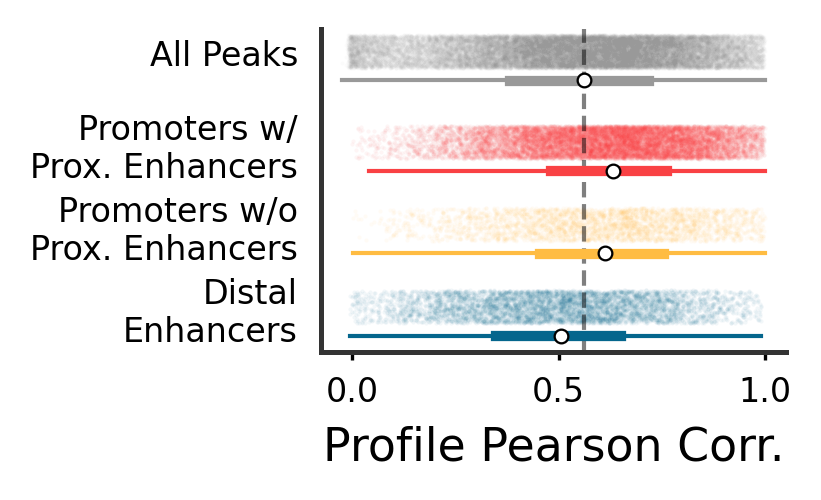

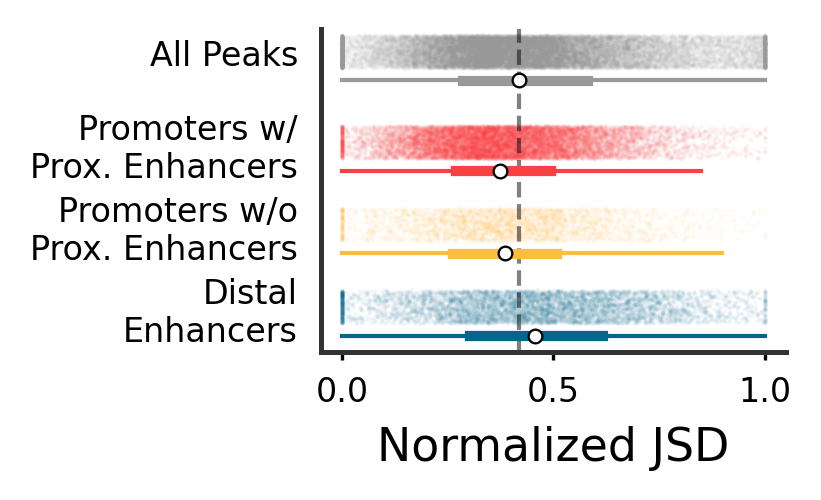

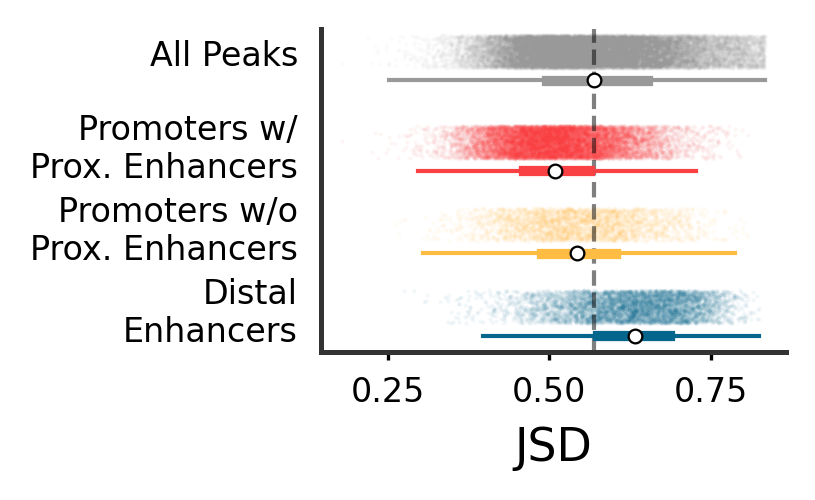

In [31]:
def plot_stratify_but_subset(metrics, ccre_annots, metric_name, save_path = None):
    
    annots_to_colors = {"PLS" : "#f94144",
                        "pELS" : "#ffbc42",
                        "dELS" : "#05668d",
                        "PLS_with_pELS" : "#f94144",
                        "PLS_no_pELS" : "#ffbc42"}

    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal\nEnhancers",
                        "dELS" : "Distal\nEnhancers",
                        "PLS_with_pELS" : "Promoters w/\nProx. Enhancers",
                        "PLS_no_pELS" : "Promoters w/o\nProx. Enhancers"}

    annots_to_plot = ["PLS_with_pELS", "PLS_no_pELS", "dELS"]
    
    
    plt.figure(figsize=(2, 1.4), dpi=300)

    # draw vertical line to show the median metric value across the whole dataset
    plt.axvline(np.median(metrics), linestyle="dashed", alpha=0.5, color="k", linewidth=1)
    
    y_index = 0
    
    # plot first row: whole dataset
    plot_scatter_and_boxplot(metrics, y_index, color="#999999", dot_alpha=0.03)
    y_index += 1
    y_labels = ["All Peaks"]
    yticks = [0]
    
    # for subsequent rows, add a small, consistent offset so the first row gets some space 
    y_offset = 0.1
    
    # for each annotation to stratify over, plot a row for that subset of the data
    for annot_name in annots_to_plot:
        y_labels.append(annots_to_labels[annot_name])
        yticks.append(y_index + y_offset)
        metrics_subset = metrics[ccre_annots[annot_name]]
        plot_scatter_and_boxplot(metrics_subset, y_index + y_offset,
                                 color = annots_to_colors[annot_name],
                                 dot_alpha = 0.05)
        y_index += 1

    plt.xlabel(metric_name, fontsize=11)
    
    plt.yticks(yticks, y_labels, fontsize = 8)
    plt.ylim(plt.gca().get_ylim()[1], plt.gca().get_ylim()[0] - 0.1)
    
    # aesthetics
    
    ax = plt.gca()
    ax.spines[["left", "bottom"]].set_linewidth(1.2)
    ax.spines[["left", "bottom"]].set_color("#333333")
    ax.spines[["top", "right"]].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.tick_params(length=2)
    plt.xticks(fontsize=8)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
    
plot_stratify_but_subset(norm_pearson_rs, ccre_annots, "Normalized Profile\n" + r'Pearson Corr.',
                         save_path = figures_dir + "1E_stratify_cCREs_norm_pearson.png")
    
plot_stratify_but_subset(pearson_rs_pred_vs_obs, ccre_annots, "Profile Pearson Corr.",
                         save_path = figures_dir + "1E_stratify_cCREs_pearson.png")

plot_stratify_but_subset(norm_jsds, ccre_annots, "Normalized JSD",
                         save_path = figures_dir + "1E_stratify_cCREs_norm_jsd.png")
    
plot_stratify_but_subset(jsds_pred_vs_obs, ccre_annots, "JSD",
                         save_path = figures_dir + "1E_stratify_cCREs_jsd.png")

## More Stratification (Supplement)

PLS_with_pELS
Pred. vs. Obs. MSE: 0.5910192
Pred vs. Obs Pearson r: 0.47564733178578605
Pred vs. Obs Spearman r: 0.45058833322636

PLS_no_pELS
Pred. vs. Obs. MSE: 1.1794615
Pred vs. Obs Pearson r: 0.4206444921841144
Pred vs. Obs Spearman r: 0.4689887268514059

dELS
Pred. vs. Obs. MSE: 1.0544916
Pred vs. Obs Pearson r: 0.5695905136836257
Pred vs. Obs Spearman r: 0.5291510805486843



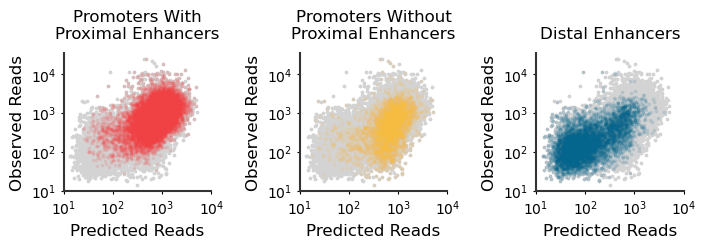

In [32]:
def plot_true_pred_counts_by_annot(true_counts, pred_logcounts, overlap_annots_bools,
                                   save_path = None):
    
    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Distal Enhancers",
                        "PLS_with_pELS" : "Promoters With\nProximal Enhancers",
                        "PLS_no_pELS" : "Promoters Without\nProximal Enhancers" }
    
    annots_to_colors = {"PLS" : "#f94144",
                        "pELS" : "#ffbc42",
                        "dELS" : "#05668d",
                        "PLS_with_pELS" : "#f94144",
                        "PLS_no_pELS" : "#ffbc42"}
    
    fig, axes = plt.subplots(1,3,figsize=(8,1.8))
    
    annots_to_plot = ["PLS_with_pELS", "PLS_no_pELS", "dELS"] #["PLS", "pELS", "dELS"]
    
    
    # get union of all the points you're going to plot as separate groups
    
    all_x = []
    all_y = []
    for annot_name in annots_to_plot:
        all_x.extend(np.exp(pred_logcounts[overlap_annots_bools[annot_name]]).squeeze())
        all_y.extend(true_counts[overlap_annots_bools[annot_name]].squeeze())
    
    
    for ax, sup_annot_name in zip(axes, annots_to_plot):
        
        # first, plot all the points in light gray as a background
        
        ax.scatter(all_x, all_y, alpha = 1, s = 3, color = "lightgray")
        
        # then get subset of dataset overlapping the annotation/cCRE label
        true_counts_subset = true_counts[overlap_annots_bools[sup_annot_name]].squeeze()
        pred_logcounts_subset = pred_logcounts[overlap_annots_bools[sup_annot_name]].squeeze()
        
        # print some stats to report in text
        
        mse = np.mean((pred_logcounts_subset - np.log1p(true_counts_subset)) ** 2)
        print(sup_annot_name)
        print("Pred. vs. Obs. MSE:", mse)
        print("Pred vs. Obs Pearson r:", np.corrcoef(pred_logcounts_subset, np.log1p(true_counts_subset))[0,1])
        print("Pred vs. Obs Spearman r:", spearmanr(pred_logcounts_subset,
                                                    np.log1p(true_counts_subset)).correlation)
        print("")
        
        # plot the subset of the dataset overlapping this annotation/cCRE
        
        ax.scatter(np.exp(pred_logcounts_subset), true_counts_subset, alpha = 0.1, s = 3,
                    label = annots_to_labels[sup_annot_name],
                    color = annots_to_colors[sup_annot_name])

        # aesthetics
        
        ax.semilogy()
        ax.semilogx()

        ax.set_xlabel("Predicted Reads", fontsize = 12)
        ax.set_ylabel("Observed Reads", fontsize = 12)

        ax.spines[["left", "bottom"]].set_linewidth(1.5)
        ax.spines[["left", "bottom"]].set_color("#333333")
        ax.spines[["top", "right"]].set_visible(False) 
        ax.tick_params(axis='both', labelsize=10, length=2)
        
        ax.set_xticks([10, 10**2, 10**3, 10**4])
        ax.set_yticks([10, 10**2, 10**3, 10**4])
        ax.minorticks_off()
        
        ax.set_title(annots_to_labels[sup_annot_name], fontsize=12, pad=10)

    plt.subplots_adjust(wspace=0.6)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()

    
plot_true_pred_counts_by_annot(true_counts.sum(axis=-1), pred_logcounts, ccre_annots,
                               save_path = figures_dir + "S1_counts_by_ccre.png")

In [33]:
# calculate overall MSE

mse = np.mean((pred_logcounts - np.log1p(true_counts.sum(axis=-1))) ** 2)
mse

0.90864563

### Stratify by TATA box presence (based on motif hits)

In [34]:
peak_hit_counts = load_motif_hits(cell_type, model_type, data_type, in_window=in_window)[-1]

In [35]:
# create a boolean list, where element i is True if PRO-cap peak i contains a TATA box

# the function below is general enough to work for any motif name found in the motif hits

def get_filter_for_peaks_with_motif(peak_hit_counts, motif_key_labels, motifs_to_find):
    # motif_key_labels should be a list of motif names, the same list used
    # when motif hits were called. The order must be kept the same too
    
    motif_bools = dict()
    for motif in motifs_to_find:
        assert motif in motif_key_labels, (motif, motif_key_labels)
        motif_index = motif_key_labels.index(motif)
        motif_bools[motif] = peak_hit_counts["profile"][:, motif_index] > 0

    return motif_bools

motif_filters = get_filter_for_peaks_with_motif(peak_hit_counts, motif_names,
                                                ["TATA", "TATATA"])

# since we found two forms of the TATA box, we'll just merge the list for each into one

motif_filters = {"TATA" : np.logical_or(motif_filters["TATA"], motif_filters["TATATA"])}

In [36]:
# similar to how we found overlap between peaks and cCRE annotations,
# we can do bedtools-intersect-like logic to find peaks overlapping 
# annotations of housekeeping or TCT promoters

# (see scripts in the 1_process_data/ folder for how these bed files were made)

housekeeping_genes_bed = proj_dir + "/annotations/hk_promoters_by_transcripts.bed"
hk_annots = find_peak_overlap(all_coords, housekeeping_genes_bed)

tct_promoters_bed = proj_dir + "/annotations/tct_promoters.bed"
tct_annots = find_peak_overlap(all_coords, tct_promoters_bed)

In [38]:
gene_regions_files = {"genes" : proj_dir + "/annotations/gene_regions.bed",
                      "TSSs" : proj_dir + "/annotations/TSSs.bed",
                      "promoters" : proj_dir + "/annotations/promoters.bed",
                      "intergenic" : proj_dir + "/annotations/intergenic_regions.bed",
                      "exons" : proj_dir + "/annotations/exons.bed",
                      "introns" : proj_dir + "/annotations/introns.bed",
                      "utrs" : proj_dir + "/annotations/utrs.bed"}

gene_region_annots = get_gene_region_overlap(all_coords, gene_regions_files)

In [39]:
# calculate distance between each PRO-cap peak center and the nearest GENCODE-annotated TSS

TSS_dists = get_dist_to_TSS(all_coords, gene_regions_files["TSSs"])

In [40]:
# we want to contrast peaks in promoters against peaks not in promoters,
# but promoters technically overlap gene bodies by a little and intergenic regions too.
# so, we'll adjust our labels for what type of genomic region a PRO-cap peak falls in
# by making sure promoter-overlaps are labeled as such, and only non-promoter-overlaps
# have other labels, like genic or intergenic.

gene_region_names = list(gene_region_annots.keys())
for region in gene_region_names:
    if "promoters" in region or "TSSs" in region:
        continue
    if "_not_TSS" in region:  # this is here to avoid bugs if you re-run this cell again
        continue
        
    gene_region_annots[region + "_not_TSS"] = gene_region_annots[region] * (~ gene_region_annots["promoters"])

In [41]:
# look at some stats about how these annotations overlap:

In [42]:
ccre_annots["PLS"].sum()

16960

In [43]:
# not perfect agreement between "PLS" category and GENCODE-transcript promoters :/
(ccre_annots["PLS"] * gene_region_annots["promoters"]).sum()

14519

In [44]:
# how many PRO-cap peaks overlap both a gene body and a region outside a gene body?
# (how many peaks are on the boundary of a gene, like a promoter should be)
(gene_region_annots["genes"] * gene_region_annots["intergenic"]).sum()

5040

In [45]:
# 91% of peaks on gene boundaries are actually annotated as promoters, good
(gene_region_annots["genes"] * gene_region_annots["intergenic"] * ccre_annots["PLS"]).sum()

4602

In [46]:
# 4790 out of 5040 gene-boundary peaks are actually annotated as promoters *or* proximal enhancers
(gene_region_annots["genes"] * gene_region_annots["intergenic"] * np.logical_or(ccre_annots["pELS"], ccre_annots["PLS"])).sum()

4790

In [47]:
# all of those overlap an exon annotation as well, makes sense
(gene_region_annots["genes"] * gene_region_annots["intergenic"] * gene_region_annots["exons"] * ccre_annots["PLS"]).sum()

4602

In [48]:
# most of them overlap a UTR annotation (so are for coding genes)
(gene_region_annots["genes"] * gene_region_annots["intergenic"] * gene_region_annots["utrs"] * ccre_annots["PLS"]).sum()

4098

In [49]:
# most annotated promoters (15419 / 16960, 91%) overlap with gene annotations also
(gene_region_annots["genes"] * ccre_annots["PLS"]).sum()

15419

In [50]:
# how many of each region do we have?
[(k, sum(t)) for k, t in gene_region_annots.items()]

[('genes', 24916),
 ('TSSs', 11226),
 ('promoters', 17181),
 ('intergenic', 10658),
 ('exons', 16329),
 ('introns', 13704),
 ('utrs', 11953),
 ('genes_not_TSS', 9148),
 ('intergenic_not_TSS', 4241),
 ('exons_not_TSS', 2397),
 ('introns_not_TSS', 7214),
 ('utrs_not_TSS', 961)]

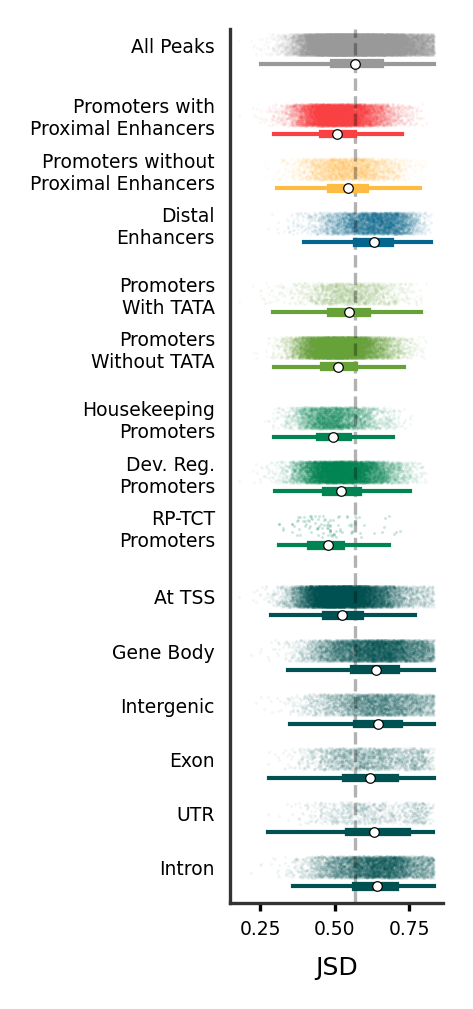

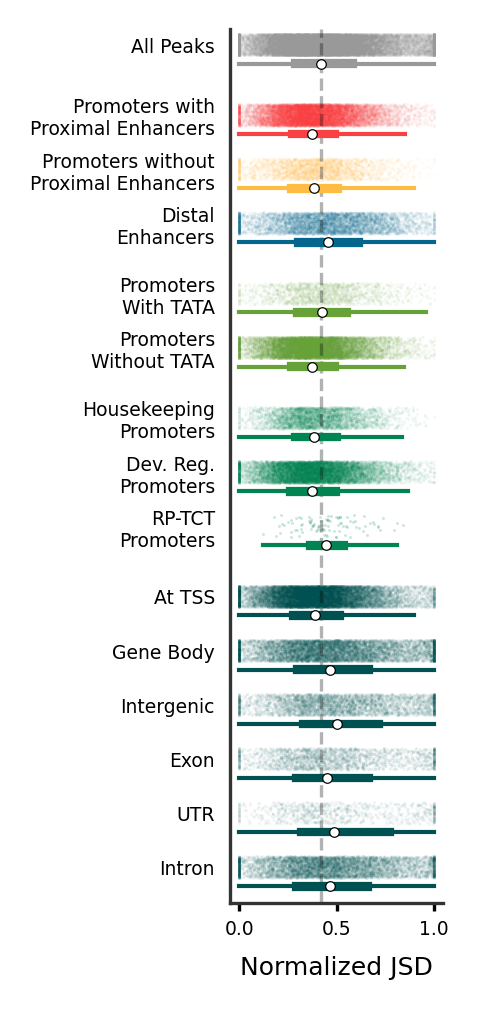

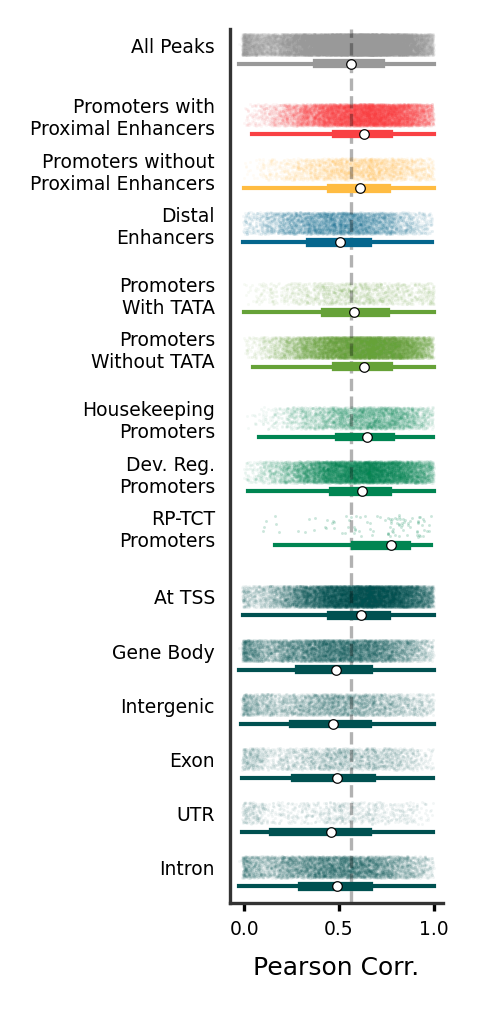

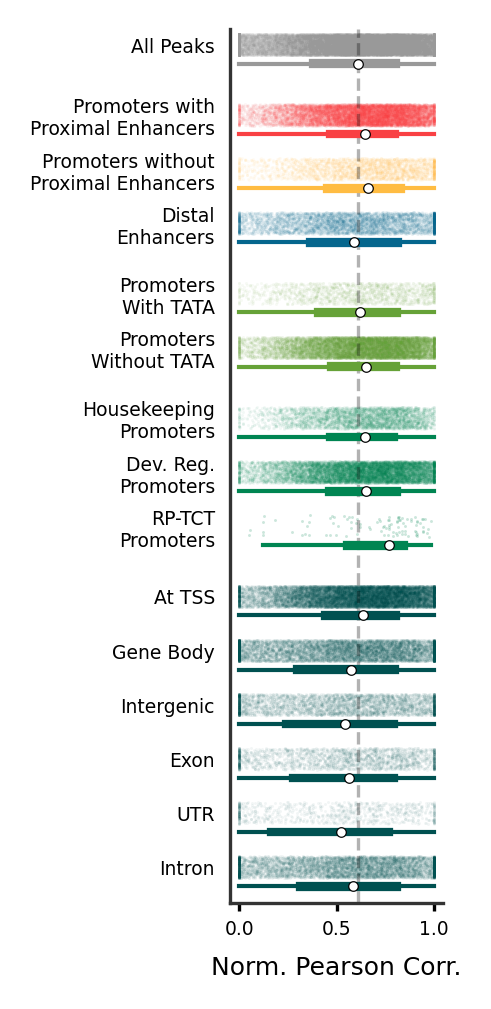

In [51]:
def plot_stratify(metrics, ccre_annots, hk_annots, tct_annots, gene_region_annots,
                  motif_filters, motif_keys_labels, metric_name, x_axis_0_to_1 = True,
                  save_path=None):
    
    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal\nEnhancers",
                        "dELS" : "Distal\nEnhancers",
                        "PLS_with_pELS" : "Promoters with\nProximal Enhancers",
                        "PLS_no_pELS" : "Promoters without\nProximal Enhancers"}
    
    regions_to_labels = {"promoters" : "At TSS",
                        "genes" : "Gene Body",
                        "genes_not_TSS" : "Gene Body",
                        "exons" : "Exon",
                        "exons_not_TSS" : "Exon",
                        "intergenic" : "Intergenic",
                        "intergenic_not_TSS" : "Intergenic",
                        "utrs" : "UTR",
                        "utrs_not_TSS" : "UTR",
                        "introns" : "Intron",
                        "introns_not_TSS" : "Intron",}
    regions_to_plot = ["promoters", "genes_not_TSS", "intergenic_not_TSS",
                       "exons_not_TSS", "utrs_not_TSS", "introns_not_TSS"]

    annots_to_labels_hk =  {"hk" : "Housekeeping\nPromoters",
                             "not-hk" : "Dev. Reg.\nPromoters"}

    annots_to_labels_tct =  {"tct" : "RP-TCT\nPromoters"}

    annots_to_plot = ["PLS_with_pELS", "PLS_no_pELS", "dELS"]

    
    y_labels = []
    
    plt.figure(figsize=(0.8 * 1.15, 3.6 * 1.05), dpi=300)

    plt.axvline(np.median(metrics), linestyle="dashed", alpha=0.3, color="k", linewidth=0.8)
    
    num_groups = 7
    groupings = [0] + [1 + i for i in range(len(annots_to_plot))]
    for i in range(len(motif_filters)):
        groupings += [i + groupings[-1] + 1] * 2
    groupings += [len(motif_filters) + len(annots_to_plot) + 1] * len(annots_to_labels_hk)
    groupings += [len(motif_filters) + len(annots_to_plot) + 1] * len(annots_to_labels_tct)
    groupings += [len(motif_filters) + len(annots_to_plot) + 2] * len(regions_to_labels)
    assert max(groupings) == num_groups - 1, (num_groups, groupings)
    
    #color_list = ["k", "#6A4C93", "#4267AC", "#52A675", "#FFCA3A", "#FF924C", "#FF596F"]
    color_list = ["#999999", "#f94144", "#ffbc42", "#05668d", "#66A238", "#008552", "#005151"]
    dot_size=0.5
    dot_alpha=0.05
    
    y_index = 0
    y_labels.append("All Peaks")
    plot_scatter_and_boxplot(metrics, y_index, color=color_list[groupings[y_index]],
                             dot_size=dot_size, dot_alpha=dot_alpha, white_dot_size=1)
    y_index += 1
    y_offset = 0.3
    yticks = [0]
    
    for annot_name in annots_to_plot:
        y_labels.append(annots_to_labels[annot_name])
        yticks.append(y_index + y_offset)

        plot_scatter_and_boxplot(metrics[ccre_annots[annot_name]],
                                 y_index + y_offset,
                                 color = color_list[groupings[y_index]],
                                 dot_size=dot_size, dot_alpha=dot_alpha, white_dot_size=1)
        y_index += 1
    
    y_offset += 0.3
    
    for motif in motif_filters.keys():
        y_labels.append("Promoters\nWith " + motif)
        yticks.append(y_index + y_offset)

        plot_scatter_and_boxplot(metrics[ccre_annots["PLS"] * motif_filters[motif]],
                                 y_index + y_offset,
                                 color = color_list[groupings[y_index]],
                                 dot_size=dot_size, dot_alpha=dot_alpha, white_dot_size=1)
        y_index += 1
        
        y_labels.append("Promoters\nWithout " + motif)
        yticks.append(y_index + y_offset)

        plot_scatter_and_boxplot(metrics[ccre_annots["PLS"] * (~ motif_filters[motif])],
                                 y_index + y_offset,
                                 color = color_list[groupings[y_index]],
                                 dot_size=dot_size, dot_alpha=dot_alpha, white_dot_size=1)
        y_index += 1
        
    y_offset += 0.3
    
    for annot_name in annots_to_labels_hk.keys():
        y_labels.append(annots_to_labels_hk[annot_name])
        yticks.append(y_index + y_offset)
        
        if annot_name == "hk":
            metrics_subset = metrics[ccre_annots["PLS"] * hk_annots]
        else:
            metrics_subset = metrics[ccre_annots["PLS"] * (~ hk_annots)]

        plot_scatter_and_boxplot(metrics_subset, y_index + y_offset,
                                 color = color_list[groupings[y_index]],
                                 dot_size=dot_size, dot_alpha=dot_alpha, white_dot_size=1)
        y_index += 1
        
        
    for annot_name in annots_to_labels_tct.keys():
        if annot_name == "tct":
            y_labels.append(annots_to_labels_tct[annot_name])
            yticks.append(y_index + y_offset)

            plot_scatter_and_boxplot(metrics[ccre_annots["PLS"] * tct_annots],
                                     y_index + y_offset,
                                     color = color_list[groupings[y_index]],
                                     dot_size=dot_size, dot_alpha=dot_alpha, white_dot_size=1)
            y_index += 1
        
    y_offset += 0.3
        
    for region_name in regions_to_plot:
        y_labels.append(regions_to_labels[region_name])
        yticks.append(y_index + y_offset)
        
        metrics_subset = metrics[gene_region_annots[region_name]]
        plot_scatter_and_boxplot(metrics_subset, y_index + y_offset,
                                 color = color_list[groupings[y_index]],
                                 dot_size=dot_size, dot_alpha=dot_alpha, white_dot_size=1)
        y_index += 1
        
        
    plt.xlabel(metric_name, fontsize=6)
    
    # aesthetics
    ax = plt.gca()
    #ax.spines[["left", "bottom"]].set_linewidth(1.2)
    ax.spines[["left", "bottom"]].set_color("#333333")
    ax.spines[["top", "right"]].set_visible(False) 
    ax.yaxis.set_ticks_position('none')
    plt.tick_params("y", length=0, labelsize=4.5)
    plt.tick_params("x", length=2, labelsize=4.5, pad=2)
    
    if x_axis_0_to_1:
        plt.xticks([0, 0.5, 1])
    plt.yticks(yticks, y_labels)
    
    plt.ylim(plt.gca().get_ylim()[1] - 0.5, plt.gca().get_ylim()[0] + 0.5)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0)
    
    plt.show()
    
    
plot_stratify(jsds_pred_vs_obs, ccre_annots,
              hk_annots, tct_annots, gene_region_annots,
              motif_filters, motif_names, metric_name="JSD", x_axis_0_to_1=False,
              save_path = figures_dir + "S1_stratified_jsd.png")
    
plot_stratify(norm_jsds, ccre_annots,
              hk_annots, tct_annots, gene_region_annots,
              motif_filters, motif_names, metric_name="Normalized JSD",
              save_path = figures_dir + "S1_stratified_norm_jsd.png")

plot_stratify(pearson_rs_pred_vs_obs, ccre_annots,
              hk_annots, tct_annots, gene_region_annots,
              motif_filters, motif_names, metric_name="Pearson Corr.",
              save_path = figures_dir + "S1_stratified_norm_pearson.png")

plot_stratify(norm_pearson_rs, ccre_annots,
              hk_annots, tct_annots, gene_region_annots,
              motif_filters, motif_names, metric_name="Norm. Pearson Corr.",
              save_path = figures_dir + "S1_stratified_norm_pearson.png")

In [52]:
low_JSD_site_indexes = (norm_jsds > 0.9).squeeze()

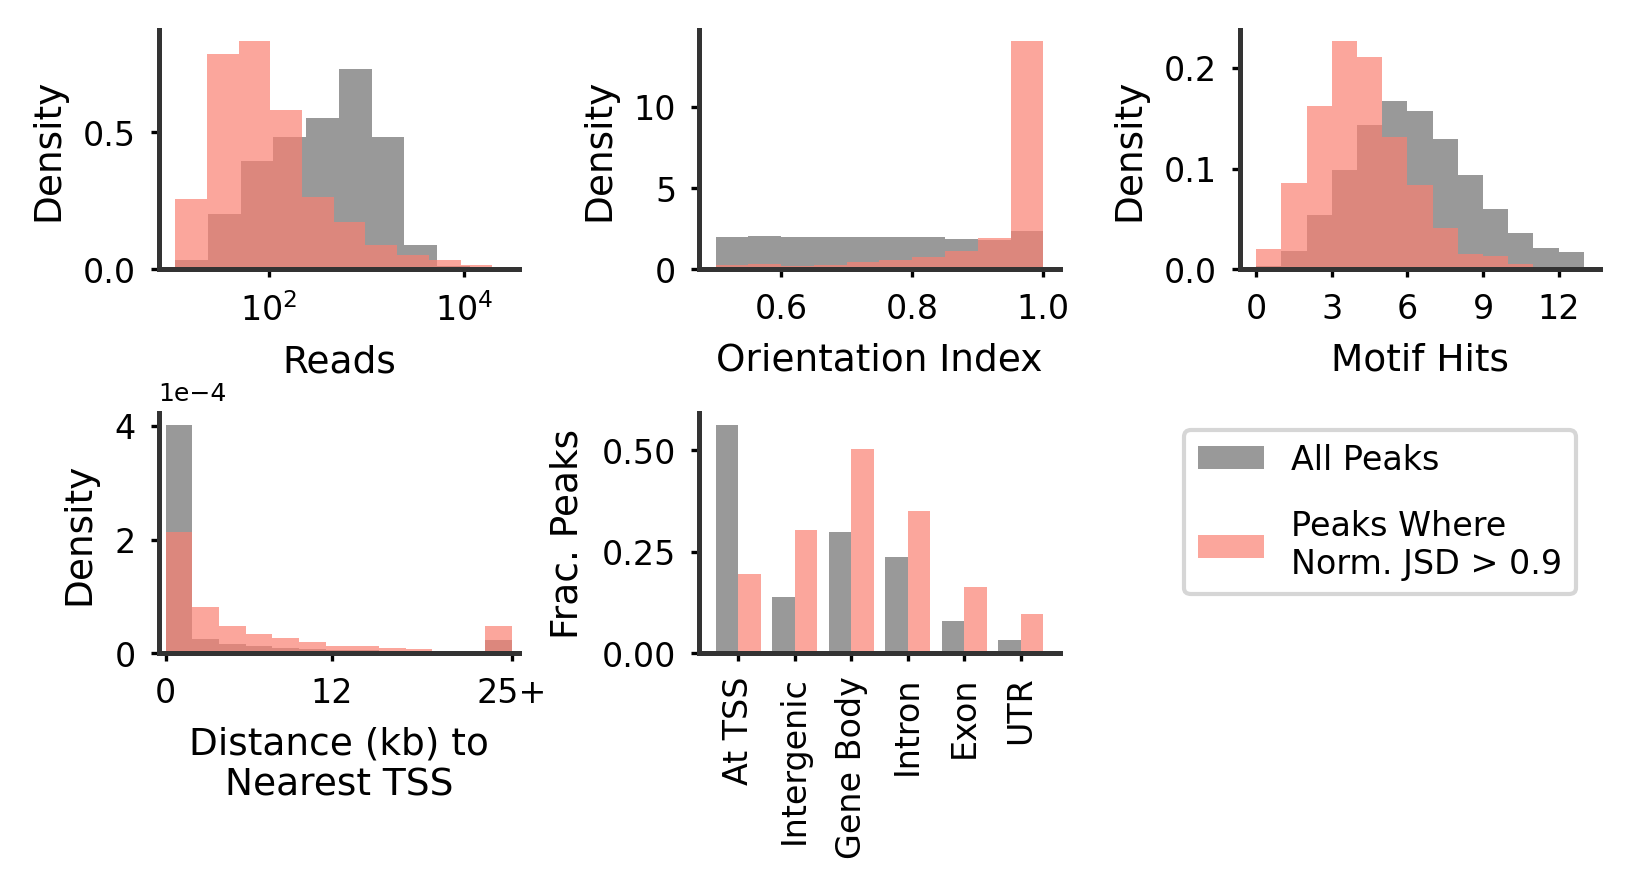

In [53]:
def make_ax_pretty(ax, linewidth=1.2, ax_color = "#333333", ticklabelsize=8):
    ax.spines[["left", "bottom"]].set_linewidth(linewidth)
    ax.spines[["left", "bottom"]].set_color(ax_color)
    ax.spines[["top", "right"]].set_visible(False)
    ax.tick_params(length=2, labelsize=ticklabelsize)
    

def make_plots_for_outliers(outlier_indexes, true_profs, true_counts,
                               peak_hit_counts, gene_region_annots, TSS_dists,
                           save_path=None):
    
    # you have to manually change this if you change the threshold above. sorry
    group_names = ["All Peaks", "Peaks Where\nNorm. JSD > 0.9"]
    
    regions_to_labels = {"promoters" : "At TSS",
                        "genes" : "Gene Body",
                        "genes_not_TSS" : "Gene Body",
                        "exons" : "Exon",
                        "exons_not_TSS" : "Exon",
                        "intergenic" : "Intergenic",
                        "intergenic_not_TSS" : "Intergenic",
                        "utrs" : "UTR",
                        "utrs_not_TSS" : "UTR",
                        "introns" : "Intron",
                        "introns_not_TSS" : "Intron"}
    regions_to_plot = ["promoters", "intergenic_not_TSS", "genes_not_TSS",
                       "introns_not_TSS", "exons_not_TSS", "utrs_not_TSS"]
    
    fig, axes = plt.subplots(2, 3, figsize=(6.2,2.7), dpi=300)
    plt.subplots_adjust(wspace=0.5, hspace=0.6)
    axes = axes.flatten()
    
    # Counts histogram
    
    log_all_true_counts = np.log10(true_counts.sum(axis=1) + 1)
    log_outlier_true_counts = np.log10(true_counts[outlier_indexes].sum(axis=1) + 1)
    
    axes[0].hist(log_all_true_counts, alpha=0.8, density=True, color="gray")
    axes[0].hist(log_outlier_true_counts, alpha=0.7, density=True, color="salmon")
    
    axes[0].set_xlabel("Reads", fontsize=9)
    axes[0].set_ylabel("Density", fontsize=9)
    
    xticks = [2,4]
    axes[0].set_xticks(xticks, [r'$10^{' + str(i) + r'}$' for i in xticks])
    
    # OI histogram
    
    ois = get_orientation_indexes(true_profs)
    
    axes[1].hist(ois,
                 alpha=0.8, density=True, color="gray")
    axes[1].hist(ois[outlier_indexes],
                 alpha=0.7, density=True, color="salmon")
    
    axes[1].set_xlabel("Orientation Index", fontsize=9)
    axes[1].set_ylabel("Density", fontsize=9)
    
    # Motif hits histogram
    
    motif_hits = peak_hit_counts.sum(axis=1)
    axes[2].hist(motif_hits,
             bins=range(14), alpha=0.8, density=True, color="gray")
    axes[2].hist(motif_hits[outlier_indexes],
             bins=range(14), alpha=0.7, density=True, color="salmon")
    
    axes[2].set_xlabel("Motif Hits", fontsize=9)
    axes[2].set_ylabel("Density", fontsize=9)
    
    axes[2].set_xticks(range(0,14,3))
    
    # TSS distances histogram

    stop_point = 25000
    num_bins = int(np.ceil(stop_point / 2000))
    axes[3].hist([min(d, stop_point) for d in TSS_dists if d is not None],
             density=True, bins=num_bins,
             alpha=0.8, color="gray")
    axes[3].hist([min(d, stop_point) for d in TSS_dists[outlier_indexes] if d is not None],
             density=True, bins=num_bins,
             alpha=0.7, color="salmon")

    axes[3].set_xlim(-500, stop_point + 500)
    axes[3].set_xlabel("Distance (kb) to\nNearest TSS", fontsize=9)
    axes[3].set_ylabel("Density", fontsize=9)
    axes[3].ticklabel_format(axis="y", style="scientific", scilimits=(0,0))
    axes[3].yaxis.offsetText.set_fontsize(6)
    
    middle_tick = int(stop_point / 2000) * 1000
    axes[3].set_xticks([0, middle_tick, stop_point],
                       ["0", middle_tick // 1000, str(stop_point // 1000) + "+"])
    
    # Gene annotation regions double bar plot

    fracs_overall = []
    fracs_in_region = []
    for region_name in regions_to_plot:
        region_bools = gene_region_annots[region_name]
        frac_overall = sum(region_bools) / len(region_bools)
        frac_in_region = sum(region_bools[outlier_indexes]) / len(region_bools[outlier_indexes])
        fracs_overall.append(frac_overall)
        fracs_in_region.append(frac_in_region)

    barplot_x_vals = np.arange(len(fracs_overall))
    bar_width = 0.4
    b1 = axes[4].bar(barplot_x_vals, fracs_overall,
                 width=bar_width, label=group_names[0], color="gray", alpha=0.8)
    # Same thing, but offset the x.
    b2 = axes[4].bar(barplot_x_vals + bar_width, fracs_in_region,
                 width=bar_width, label=group_names[1], color="salmon", alpha=0.7)

    # x axis ticks need to be offset to go under center of two bars
    axes[4].set_xticks(barplot_x_vals + bar_width / 2,
                       labels=[regions_to_labels[region_name] for region_name in regions_to_plot],
                       rotation=90, fontsize=6)
    axes[4].set_ylabel("Frac. Peaks", fontsize=9)
    axes[4].set_yticks([0, 0.25, 0.5])

    # will function as legend for all subplots
    axes[4].legend(bbox_to_anchor=(1.3,1), loc="upper left",
               frameon=True, labelspacing=1, fontsize=8)
    
    
    # cosmetics for each subplot
    for axis in axes:
        make_ax_pretty(axis)
    
    # disappear unused axis
    axes[-1].remove()
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    
    plt.show()
    
    
make_plots_for_outliers(low_JSD_site_indexes, true_profs, true_counts,
                           peak_hit_counts["profile"], gene_region_annots, TSS_dists,
                        save_path = figures_dir + "S1_outliers.png")

In [54]:
print(np.sum(ois == 1), np.sum(ois[low_JSD_site_indexes] == 1))
print(np.sum(ois[low_JSD_site_indexes] == 1) / np.sum(ois == 1))

1312 771
0.5876524390243902


In [55]:
print(np.sum(ois[low_JSD_site_indexes] == 1), np.sum(low_JSD_site_indexes))
print(np.sum(ois[low_JSD_site_indexes] == 1) / np.sum(low_JSD_site_indexes))

771 1748
0.44107551487414187


In [56]:
np.sum(low_JSD_site_indexes) / true_profs.shape[0]

0.057247658348071

In [57]:
# load in "profiles" of binarized mappability tracks

umap_masks = extract_peaks(merged_config.genome_path,
                           merged_config.chrom_sizes,
                           merged_config.plus_bw_path,
                           merged_config.minus_bw_path,
                           merged_config.all_peak_path,
                           mask_bw_path=merged_config.mask_bw_path,
                           in_window=in_window,
                           out_window=out_window,
                           max_jitter=0, verbose=True)[-1][:, 0, :]

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:08<00:00,  2.79it/s]
Loading Peaks: 30534it [00:44, 686.62it/s]


== In Extract Peaks ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Sequence length (with jitter): 2114
Profile length (with jitter): 1000
Max jitter applied: 0
Num. Examples: 30534
Mask loaded? True


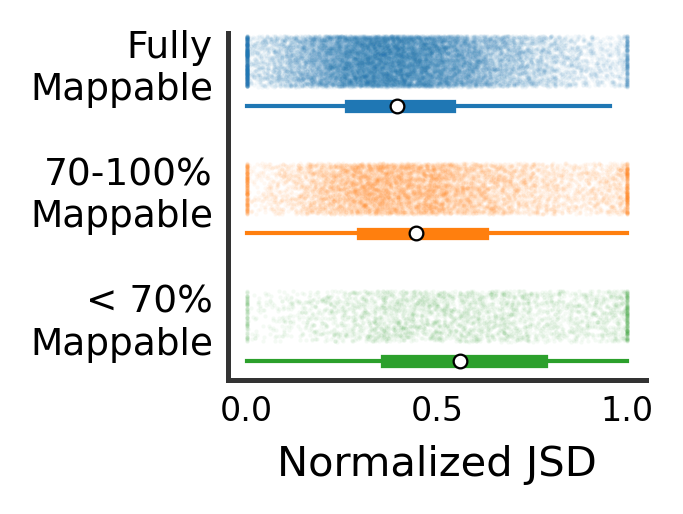

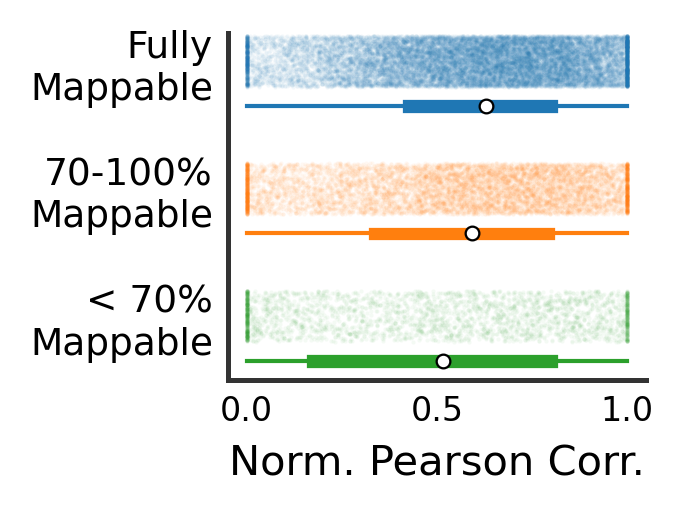

In [58]:
def plot_mappability_vs_performance(metrics, umap_masks, metric_name, save_path=None):
    # what fraction of bases in the model output window are uniquely mappable?
    umap_frac = umap_masks.mean(axis=-1)

    # make boolean lists for whether each peak's mappability is within 3 bins
    umap_all_mappable = umap_frac == 1  # 100% mappable
    umap_mostly_mappable = (umap_frac < 1) * (umap_frac >= 0.7)  # between 70% and 100% mappable
    umap_least_mappable = umap_frac < 0.7  # less than 70% mappable

    plt.figure(figsize=(1.8, 1.5), dpi=300)
    
    y_labels = []
    y_index = 0
    y_labels.append("Fully\nMappable")
    plot_scatter_and_boxplot(metrics[umap_all_mappable], y_index,
                             color="tab:blue", dot_alpha=0.05)
    y_index += 1
    
    y_labels.append("70-100%\nMappable")
    plot_scatter_and_boxplot(metrics[umap_mostly_mappable], y_index,
                             color="tab:orange", dot_alpha=0.05)
    y_index += 1
    
    y_labels.append("< 70%\nMappable")
    plot_scatter_and_boxplot(metrics[umap_least_mappable], y_index,
                             color="tab:green", dot_alpha=0.05)
    y_index += 1

    plt.xlabel(metric_name)
        
    # aesthetics 
    
    ax = plt.gca()
    ax.spines[["left", "bottom"]].set_linewidth(1.2)
    ax.spines[["left", "bottom"]].set_color("#333333")
    ax.spines[["top", "right"]].set_visible(False)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')

    ax.tick_params(length=0)
    plt.xticks(fontsize=8)

    plt.yticks(range(len(y_labels)), y_labels, fontsize = 9)
    plt.ylim(plt.gca().get_ylim()[1], plt.gca().get_ylim()[0] - 0.1)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    
    plt.show()



plot_mappability_vs_performance(norm_jsds, umap_masks, metric_name="Normalized JSD",
                                   save_path = figures_dir + "S1_mappability_norm_jsd.png")

plot_mappability_vs_performance(norm_pearson_rs, umap_masks, metric_name="Norm. Pearson Corr.",
                                   save_path = figures_dir + "S1_mappability_norm_pearson.png")